In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import numpy as np
import proplot as pplt
import matplotlib.pyplot as plt

import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import uncertainty_toolbox as uct
from deephyper.gnn_uq.figure import sat
from deephyper.gnn_uq.analysis import conf_level, miscal_area
from deephyper.gnn_uq.data_utils import get_data, split_data

LABEL = ['Lipo', 'ESOL', 'FreeSolv', 'QM7', 'QM9']

COLOR = []

cycle = pplt.Cycle('ggplot')
cycle2 = pplt.Cycle('Dark2')
for c in cycle:
    COLOR.append(c['color'])
for c in cycle2:
    COLOR.append(c['color'])

In [3]:
import os
import ast
import pickle
import itertools
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.optimizers.legacy import Adam
from deephyper.gnn_uq.load_data import load_data
from deephyper.gnn_uq.gnn_model import RegressionUQSpace, nll
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


if os.path.exists("/scratch/gpfs/sj0161/autognnuq/"):
    ROOT_DIR = "/scratch/gpfs/sj0161/autognnuq/"
else:
    ROOT_DIR = "../autognnuq/"

if os.path.exists("/scratch/gpfs/sj0161/autognnuq/fig/"):
    PLOT_DIR = "/scratch/gpfs/sj0161/autognnuq/fig/"
else:
    PLOT_DIR = "../autognnuq/fig/"

if os.path.exists("/scratch/gpfs/sj0161/autognnuq/result/"):
    RESULT_DIR = "/scratch/gpfs/sj0161/autognnuq/result/"
else:
    RESULT_DIR = "../autognnuq/result/"

if os.path.exists("/scratch/gpfs/sj0161/autognnuq/data/"):
    DATA_DIR = "/scratch/gpfs/sj0161/autognnuq/data/"
else:
    DATA_DIR = "../autognnuq/data/"


2024-05-19 14:23:50.970494: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-19 14:23:51.015776: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 14:23:52.689521: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
tf.keras.backend.clear_session()

SPLIT_TYPE = "811"

dataset = "qm9"

seed = 0

tasks = "u0"

data = get_data(os.path.join(DATA_DIR, f"{dataset}.csv"), tasks, max_data_size=None)

x_train_qm9, y_train_qm9, x_valid_qm9, y_valid_qm9, x_test_qm9, y_test_qm9 = split_data(
    data, split_type="random", sizes=(0.8, 0.1, 0.1), show_mol=False, seed=seed
)

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

ss = StandardScaler()
y_train_qm9 = ss.fit_transform(y_train_qm9)
y_valid_qm9 = ss.transform(y_valid_qm9)
y_test_qm9 = ss.transform(y_test_qm9)
mean = ss.mean_
std = ss.var_**0.5

In [10]:
ss2 = MinMaxScaler()
d = x_train_qm9[0]
d_ = d.reshape(-1, d.shape[-1])
d_ = ss2.fit_transform(d_)
d_ = d_.reshape(d.shape)
x_train_qm9[0] = d_

d = x_valid_qm9[0]
d_ = d.reshape(-1, d.shape[-1])
d_ = ss2.transform(d_)
d_ = d_.reshape(d.shape)
x_valid_qm9[0] = d_

d = x_test_qm9[0]
d_ = d.reshape(-1, d.shape[-1])
d_ = ss2.transform(d_)
d_ = d_.reshape(d.shape)
x_test_qm9[0] = d_

ss3 = MinMaxScaler()
d = x_train_qm9[2]
d_ = d.reshape(-1, d.shape[-1])
d_ = ss3.fit_transform(d_)
d_ = d_.reshape(d.shape)
x_train_qm9[2] = d_

d = x_valid_qm9[2]
d_ = d.reshape(-1, d.shape[-1])
d_ = ss3.transform(d_)
d_ = d_.reshape(d.shape)
x_valid_qm9[2] = d_

d = x_test_qm9[2]
d_ = d.reshape(-1, d.shape[-1])
d_ = ss3.transform(d_)
d_ = d_.reshape(d.shape)
x_test_qm9[2] = d_

In [61]:
tf.keras.backend.clear_session()

SPLIT_TYPE = "811"

dataset = "pc9"

seed = 0

tasks = ["energy", "homo", "lumo", "multi"]

data = get_data(os.path.join(DATA_DIR, f"{dataset}.csv"), tasks, max_data_size=None)

x_train_pc9, y_train_pc9, x_valid_pc9, y_valid_pc9, x_test_pc9, y_test_pc9 = split_data(
    data, split_type="random", sizes=(1.0, 0.0, 0.0), show_mol=False, seed=seed
)

In [62]:
len(y_train_pc9)

78172

In [63]:
d = x_train_pc9[0]
d_ = d.reshape(-1, d.shape[-1])
d_ = ss2.transform(d_)
d_ = d_.reshape(d.shape)
x_train_pc9[0] = d_


d = x_train_pc9[2]
d_ = d.reshape(-1, d.shape[-1])
d_ = ss3.transform(d_)
d_ = d_.reshape(d.shape)
x_train_pc9[2] = d_

In [66]:
np.unique(y_train_pc9[:, -1], return_counts=True)

(array([1., 2., 3., 4.]), array([72821,  4468,   882,     1]))

In [16]:
MODEL_DIR = os.path.join(
    ROOT_DIR, f"NEW_RE_qm9_random_0_split_811/save/model/"
)
arch_path = MODEL_DIR.split("save")[0] + "results.csv"
df = pd.read_csv(arch_path)
loss_min = []
arch_min = []
id_min = []
for i in range(len(df)):
    loss_min_ = np.argsort(df["objective"])[::-1].values[i]
    arch_min_ = df["p:arch_seq"][loss_min_]
    id_min_ = df["job_id"][loss_min_]

    if not any(np.array_equal(arch_min_, x) for x in arch_min):
        loss_min.append(loss_min_)
        arch_min.append(arch_min_)
        id_min.append(id_min_)


In [17]:
import ast

arch = arch_min[0]
name = id_min[0]
# turn str of architecture choice to a list
arch = ast.literal_eval(arch)

# define model input and output shapes
input_shape = [item.shape[1:] for item in x_train_qm9]
output_shape = [12,]
shapes = dict(input_shape=input_shape, output_shape=output_shape)

# define regression uncertainty quantification space
space = RegressionUQSpace(**shapes).build()

# load the model with a certain architecture
model = space.sample(choice=arch)
# print(model.summary())

2024-05-15 10:36:29.168623: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [18]:
if dataset == "lipo":
    batch_size = 256
    epochs = 1000
    patience = 200
    lr = 1e-3
else:
    batch_size = 512
    epochs = 1000
    patience = 200
    lr = 1e-3  # compile and train the model

model.compile(loss=nll, optimizer=Adam(learning_rate=lr))

In [19]:
# make prediction
model.load_weights(
    os.path.join(
        ROOT_DIR,
        f"NEW_POST_MODEL/post_model_qm9_random_0_split_811/best_{name}.h5",
    )
)

In [20]:
from tqdm import tqdm

In [21]:
y_test = y_train_pc9.squeeze()
y_preds = []
y_uncs = []

batch = int(np.ceil(len(x_train_pc9[0]) / 512))

for i in tqdm(range(batch), total=batch):
    x_test_ = [x_train_pc9[j][i * 512 : (i + 1) * 512] for j in range(len(x_train_pc9))]
    y_dist_ = model(x_test_)
    y_preds.append(y_dist_.loc.numpy())
    y_uncs.append(y_dist_.scale.numpy())

y_pred = np.concatenate(y_preds, axis=0).squeeze()
y_unc = np.concatenate(y_uncs, axis=0).squeeze()

100%|██████████| 153/153 [04:02<00:00,  1.58s/it]


(array([5.39593285e-07, 1.24106455e-05, 1.23566862e-04, 7.94281315e-04,
        2.99474273e-03, 7.06813244e-03, 1.01988527e-02, 1.01988527e-02,
        1.00035199e-02, 7.86187416e-04]),
 array([-158.06963644, -134.36232853, -110.65502061,  -86.94771269,
         -63.24040477,  -39.53309685,  -15.82578893,    7.88151899,
          31.58882691,   55.29613483,   79.00344275]),
 <BarContainer object of 10 artists>)

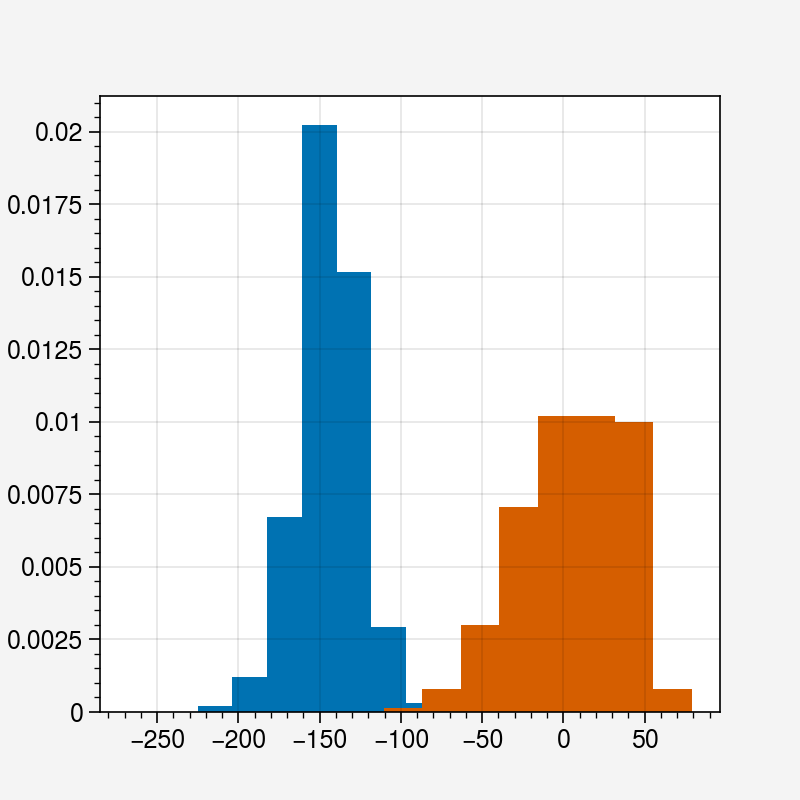

In [22]:
plt.hist(y_test[:, 1], density=True)
plt.hist(y_test[:, 2], density=True)
# plt.hist(y_train_qm9[:, 2], density=True)

(array([1.0000e+00, 6.0000e+00, 5.8000e+01, 7.6500e+02, 9.8980e+03,
        6.3017e+04, 2.8227e+04, 4.7750e+03, 3.3900e+02, 2.2000e+01]),
 array([-11.66280604, -10.77326537,  -9.88372471,  -8.99418404,
         -8.10464338,  -7.21510271,  -6.32556204,  -5.43602138,
         -4.54648071,  -3.65694005,  -2.76739938]),
 <BarContainer object of 10 artists>)

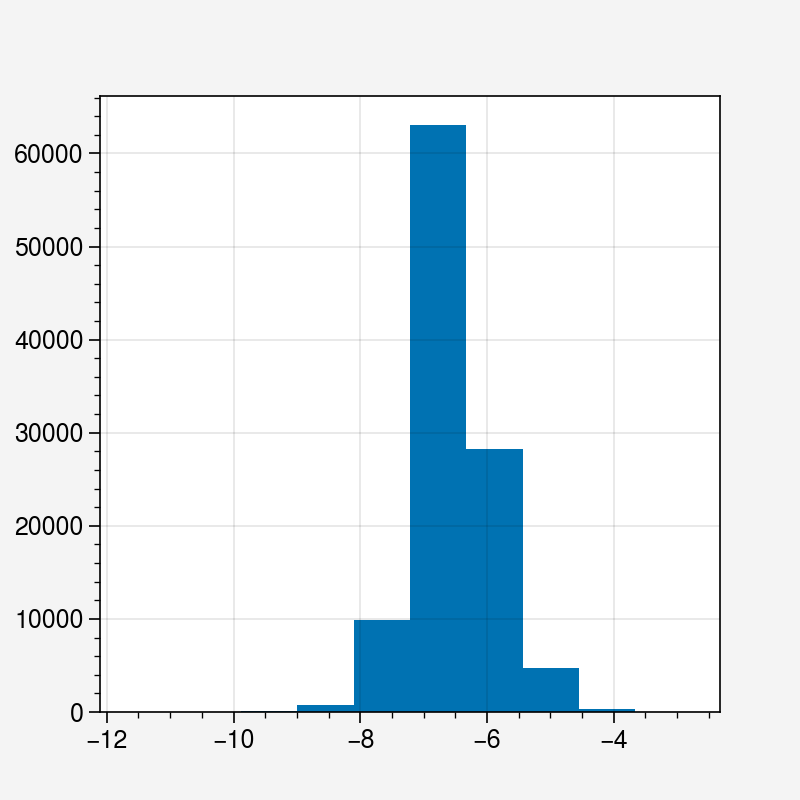

In [63]:
plt.hist((y_train_qm9[:, 2] * std[2] + mean[2]) * 27.2114)

In [58]:
std[2]

0.022170906015963415

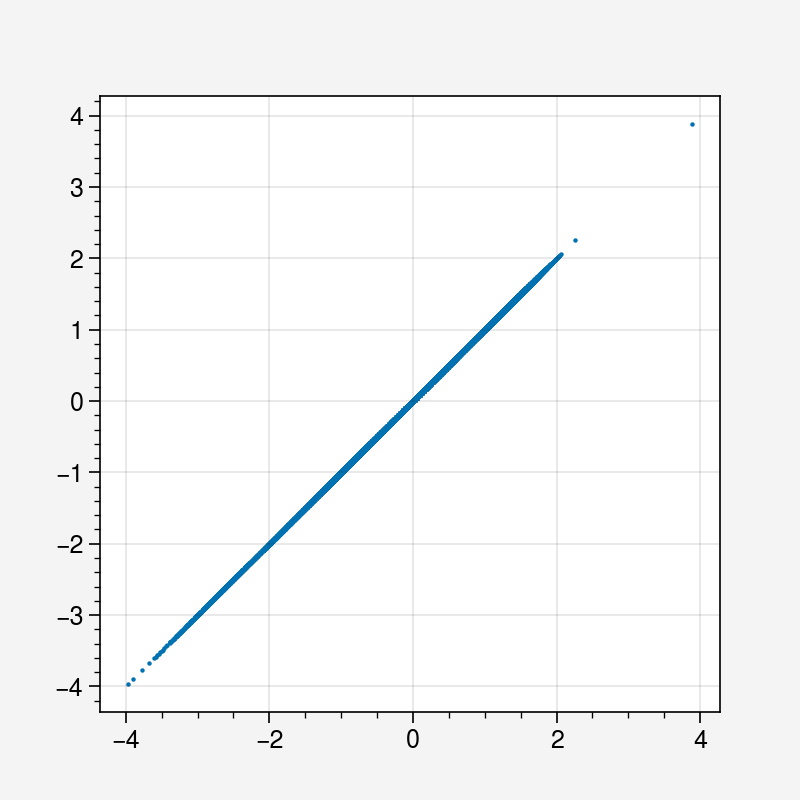

In [43]:
plt.scatter(y_train_qm9[:, 3], y_train_qm9[:, 3], s=1)

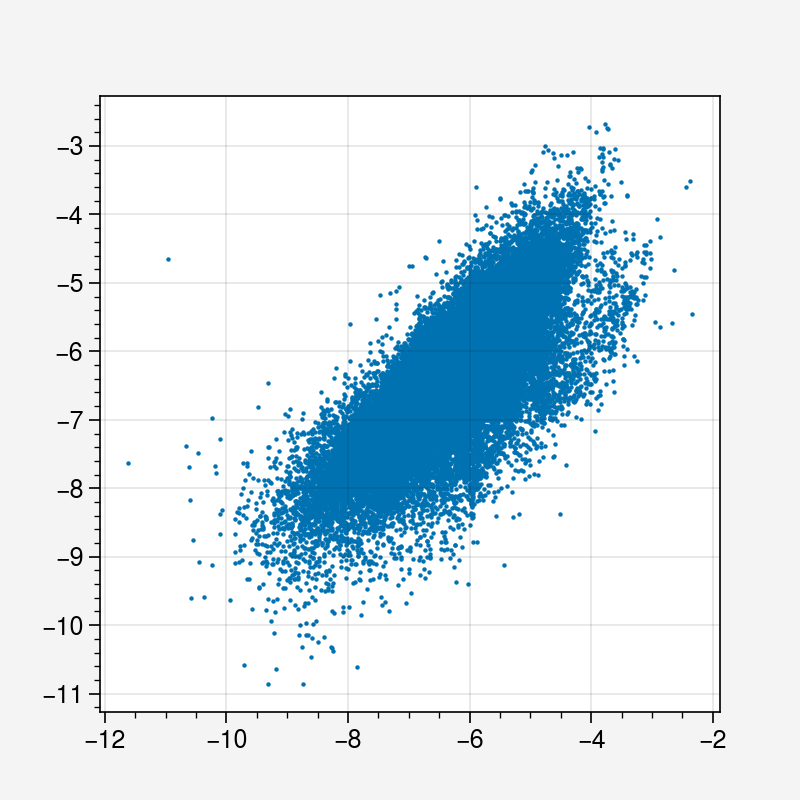

In [24]:
plt.scatter(y_test[:, 1] * 0.0433634 , (y_pred[:, 2] * std[2] + mean[2]) * 27.2114, s=1)

In [103]:
y_unc[:, -4] * std[-4]

array([0.10176183, 0.13261956, 0.08591647, ..., 0.09793521, 0.10487635,
       0.10604101], dtype=float32)

In [35]:
COLOR

['#e24a33ff',
 '#348abdff',
 '#988ed5ff',
 '#777777ff',
 '#fbc15eff',
 '#8eba42ff',
 '#ffb5b8ff',
 '#1b9e77ff',
 '#d95f02ff',
 '#7570b3ff',
 '#e7298aff',
 '#66a61eff',
 '#e6ab02ff',
 '#a6761dff',
 '#666666ff']

In [110]:
import h5py

In [182]:
file = h5py.File('/scratch/gpfs/sj0161/autognnuq/data/222.hdf5', 'r')

dataset = file['molecule']['symbols']
print(file.keys())
print(file['molecule'].keys())

cc = np.array(dataset[:])

# file.close()

<KeysViewHDF5 ['contributed_value', 'entry', 'molecule', 'value']>
<KeysViewHDF5 ['charge', 'geometry', 'multiplicity', 'schema', 'symbols']>


In [191]:
file['entry']

<KeysViewHDF5 ['entry', 'molecule_id', 'name']>

In [195]:
file['entry']["name"][:]

array([b'000000944', b'000000945', b'000000947', ..., b'057288118',
       b'059842412', b'000000281'], dtype=object)

In [172]:
file["contributed_value"]['Highest occupied molecular orbital'][:].max() * 0.043

-2.3259266155038194

In [171]:
file["contributed_value"]['Highest occupied molecular orbital'][:].min() * 0.043

-11.562175809088012

In [173]:
(y_train_qm9[:, 2] * 27).min(), (y_train_qm9[:, 2] * 27).max()

(-11.572199999999999, -2.7459)

In [180]:
smiles_bytes = cc[4]
smiles_string = ''.join([byte.decode('utf-8') for byte in smiles_bytes])
print(smiles_string)

CNCCCCCCCHHHHHHHHHHH


In [181]:

# Sanitize SMILES using RDKit
mol = Chem.MolFromSmiles(smiles_string)

if mol is not None:
    sanitized_smiles = Chem.MolToSmiles(mol)
    print("Sanitized SMILES:", sanitized_smiles)
else:
    print("Invalid SMILES string")

Invalid SMILES string


[15:00:02] SMILES Parse Error: syntax error while parsing: CNCCCCCCCHHHHHHHHHHH
[15:00:02] SMILES Parse Error: Failed parsing SMILES 'CNCCCCCCCHHHHHHHHHHH' for input: 'CNCCCCCCCHHHHHHHHHHH'


In [120]:
# Access a dataset directly


In [145]:
cc[-2]

array([b'C', b'C', b'C', b'C', b'C', b'F', b'N', b'O', b'H', b'H', b'H',
       b'H', b'H', b'H', b'H', b'H'], dtype=object)

In [146]:
from rdkit import Chem

# Create an empty editable molecule
mol = Chem.RWMol()

# Add atoms to the molecule
atoms = ['C', 'C', 'O', 'C', 'C', 'O', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
atom_indices = {}
for i, symbol in enumerate(atoms):
    atom_index = mol.AddAtom(Chem.Atom(symbol))
    atom_indices[symbol + str(i)] = atom_index

# Add bonds - you need to specify the connections between atoms
# For example, to bond the first carbon to the second carbon:
# mol.AddBond(atom_indices['C0'], atom_indices['C1'], Chem.rdchem.BondType.SINGLE)

# Convert to a normal molecule and generate SMILES
smiles = Chem.MolToSmiles(mol.GetMol())

print(smiles)


C.C.C.C.C.C.O.O.[HH].[HH].[HH].[HH].[HH].[HH].[HH].[HH].[HH].[HH].[HH].[HH].[HH].[HH]


In [127]:
file['molecule'].keys()

<KeysViewHDF5 ['charge', 'geometry', 'multiplicity', 'schema', 'symbols']>

In [11]:
import scipy.io
mat = scipy.io.loadmat('/scratch/gpfs/sj0161/autognnuq/data/qm7b.mat', )
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'T', 'names'])

In [26]:
mat["T"][:, 0]

array([ -420.93374634,  -718.41918945,  -570.02484131, ...,
       -1330.14880371, -1355.4855957 , -1494.44995117])

In [38]:
y_train[:, -4]

array([-385.930699, -362.561835, -421.745993, ..., -423.060668,
       -450.086116, -389.51257 ])

(array([3.0000e+00, 1.6900e+02, 1.4820e+03, 2.7665e+04, 3.1506e+04,
        5.6420e+03, 4.3600e+02, 2.5000e+01, 1.0000e+01, 4.0000e+00]),
 array([-15572.24002269, -14108.36416656, -12644.48831042, -11180.61245428,
         -9716.73659814,  -8252.86074201,  -6788.98488587,  -5325.10902973,
         -3861.2331736 ,  -2397.35731746,   -933.48146132]),
 <BarContainer object of 10 artists>)

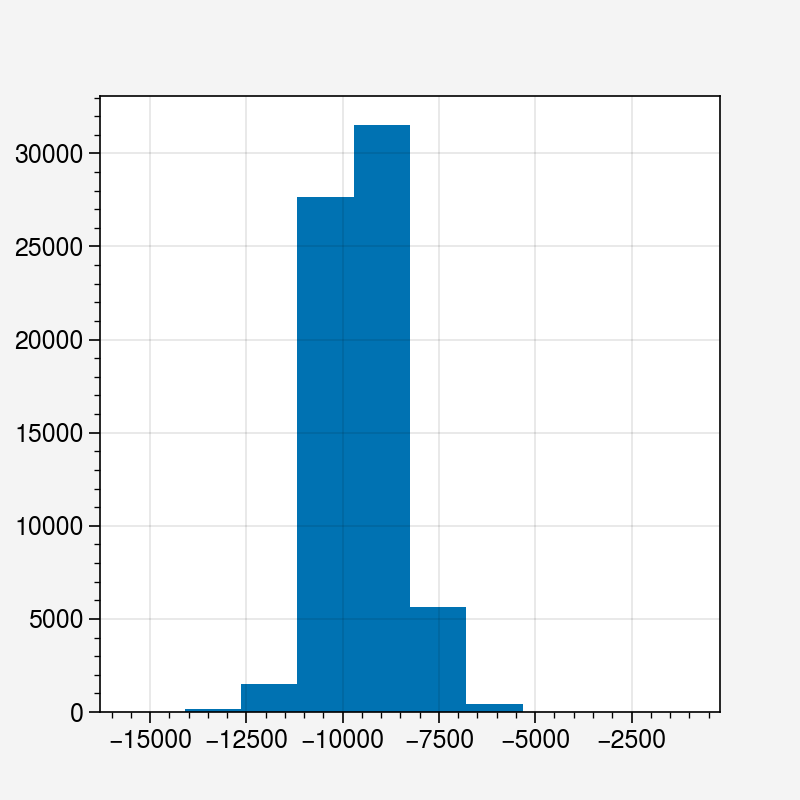

In [64]:
plt.hist(y_train[:, -4] / 0.0433634)

(array([ 42., 197., 580., 846., 905., 582., 191.,  52.,  15.,   5.]),
 array([-2191.85, -2032.3 , -1872.75, -1713.2 , -1553.65, -1394.1 ,
        -1234.55, -1075.  ,  -915.45,  -755.9 ,  -596.35]),
 <BarContainer object of 10 artists>)

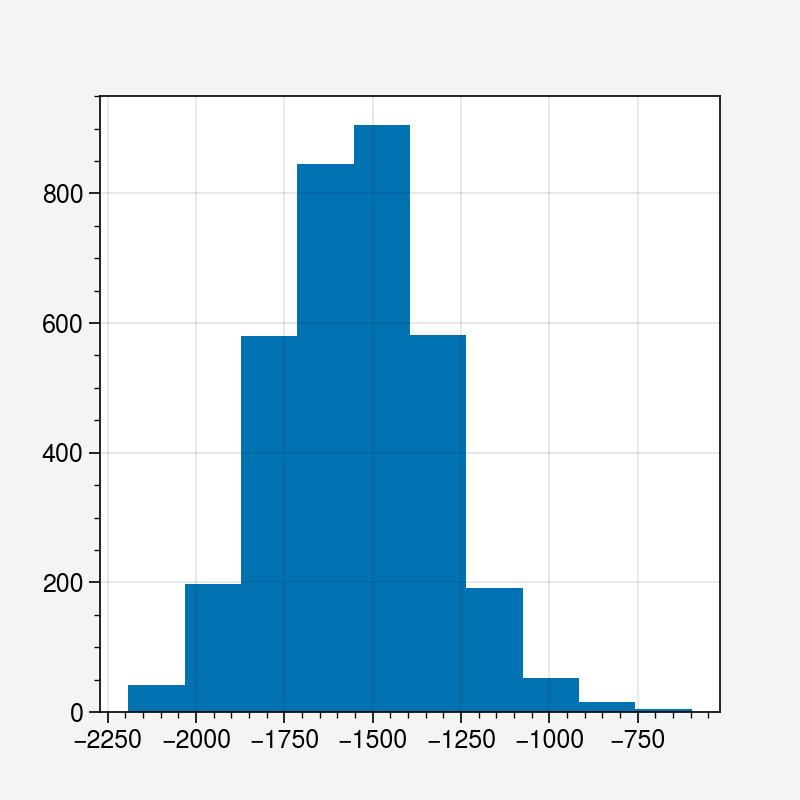

In [66]:
plt.hist(y_train)


In [4]:
from deephyper.gnn_uq.data_utils import get_data, split_data
from rdkit import Chem
from rdkit.Chem import Descriptors, MACCSkeys

from sklearn.decomposition import PCA

In [46]:
np.where(mol_pc9 == '[CH][CH]C([CH])[CH]')

(array([43381]),)

In [51]:
get_multiplicity('CCOC(C)([CH])O')

3

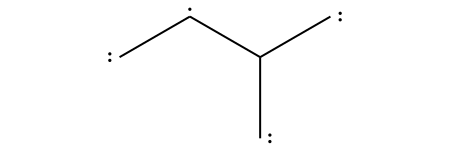

In [55]:
Chem.MolFromSmiles("[CH][CH]C([CH])[CH]")

In [54]:
np.unique(multiplicity, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 11]),
 array([72474,  4387,  1201,    41,    23,    40,     2,     1,     2,
            1]))

In [54]:
from deephyper.gnn_uq.figure import plot_pc9_pca, plot_pc9_pca_multi

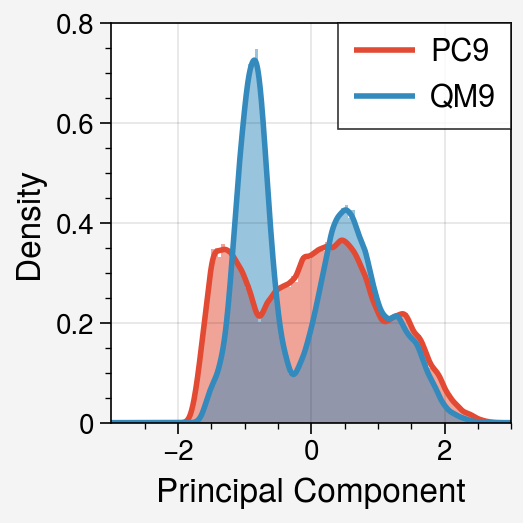

In [52]:
plot_pc9_pca(ROOT_DIR, RESULT_DIR, DATA_DIR, COLOR, PLOT_DIR, format="pdf")

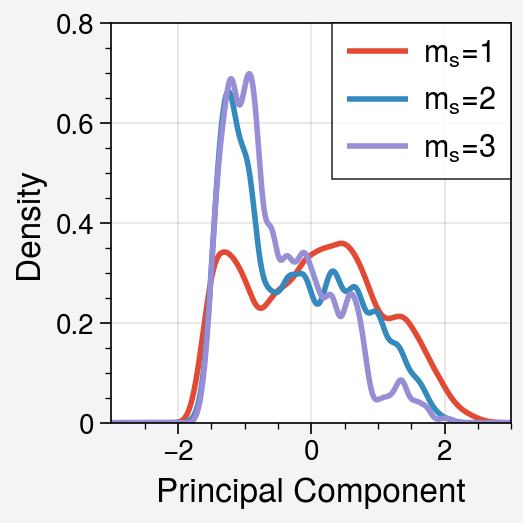

In [60]:
plot_pc9_pca_multi(ROOT_DIR, RESULT_DIR, DATA_DIR, COLOR, PLOT_DIR, format="pdf")

In [3]:
if os.path.exists("/scratch/gpfs/sj0161/autognnuq/"):
    ROOT_DIR = "/scratch/gpfs/sj0161/autognnuq/"
else:
    ROOT_DIR = "../autognnuq/"
    
if os.path.exists("/scratch/gpfs/sj0161/autognnuq/fig/"):
    PLOT_DIR = "/scratch/gpfs/sj0161/autognnuq/fig/"
else:
    PLOT_DIR = "../autognnuq/fig/"
    
if os.path.exists("/scratch/gpfs/sj0161/autognnuq/result/"):
    RESULT_DIR = "/scratch/gpfs/sj0161/autognnuq/result/"
else:
    RESULT_DIR = "../autognnuq/result/"
    
if os.path.exists("/scratch/gpfs/sj0161/autognnuq/data/"):
    DATA_DIR = "/scratch/gpfs/sj0161/autognnuq/data/"
else:
    DATA_DIR = "../autognnuq/data/"

In [48]:
for dataset in ["lipo", "delaney", "freesolv", "qm7", "qm9"]:
    t_search = []
    if dataset == "qm9":
        split = "811"
    else:
        split = "523"
    for i in range(8):
        t0 = os.path.getctime(f"/scratch/gpfs/sj0161/autognnuq/NEW_RE_{dataset}_random_{i}_split_{split}/save/config/0.0.json")
        t1 = os.path.getctime(f"/scratch/gpfs/sj0161/autognnuq/NEW_RE_{dataset}_random_{i}_split_{split}/results.csv")

        t_search.append(t1 - t0)

    t_search = np.array(t_search) / 60 

    print(f"{dataset:<8} time (hour): {t_search.mean():0.2f} ({t_search.std():0.2f})")

lipo     time (hour): 375.58 (31.62)
delaney  time (hour): 135.82 (3.84)
freesolv time (hour): 129.01 (2.29)
qm7      time (hour): 141.36 (15.40)
qm9      time (hour): 2081.16 (104.37)


In [49]:
for dataset in ["lipo", "delaney", "freesolv", "qm7", "qm9"]:
    t_search = []
    if dataset == "qm9":
        split = "811"
    else:
        split = "523"
    for i in range(8):
        
        files = glob.glob(f"/scratch/gpfs/sj0161/autognnuq/NEW_POST_RESULT/post_result_{dataset}_random_{i}_split_{split}/test_*.pickle")
        
        ts = []
        for file in files:
            ts.append(os.path.getctime(file))

        t_search.append((np.max(ts) - np.min(ts)) / (len(ts)-1))

    t_search = np.array(t_search) / 60

    print(f"{dataset:<8} time (hour): {t_search.mean():0.2f} ({t_search.std():0.2f})")

lipo     time (hour): 6.04 (1.12)
delaney  time (hour): 1.62 (0.31)
freesolv time (hour): 0.78 (0.14)
qm7      time (hour): 2.26 (0.49)
qm9      time (hour): 149.04 (41.68)


In [7]:
from deephyper.gnn_uq.figure import plot_uq_metrics

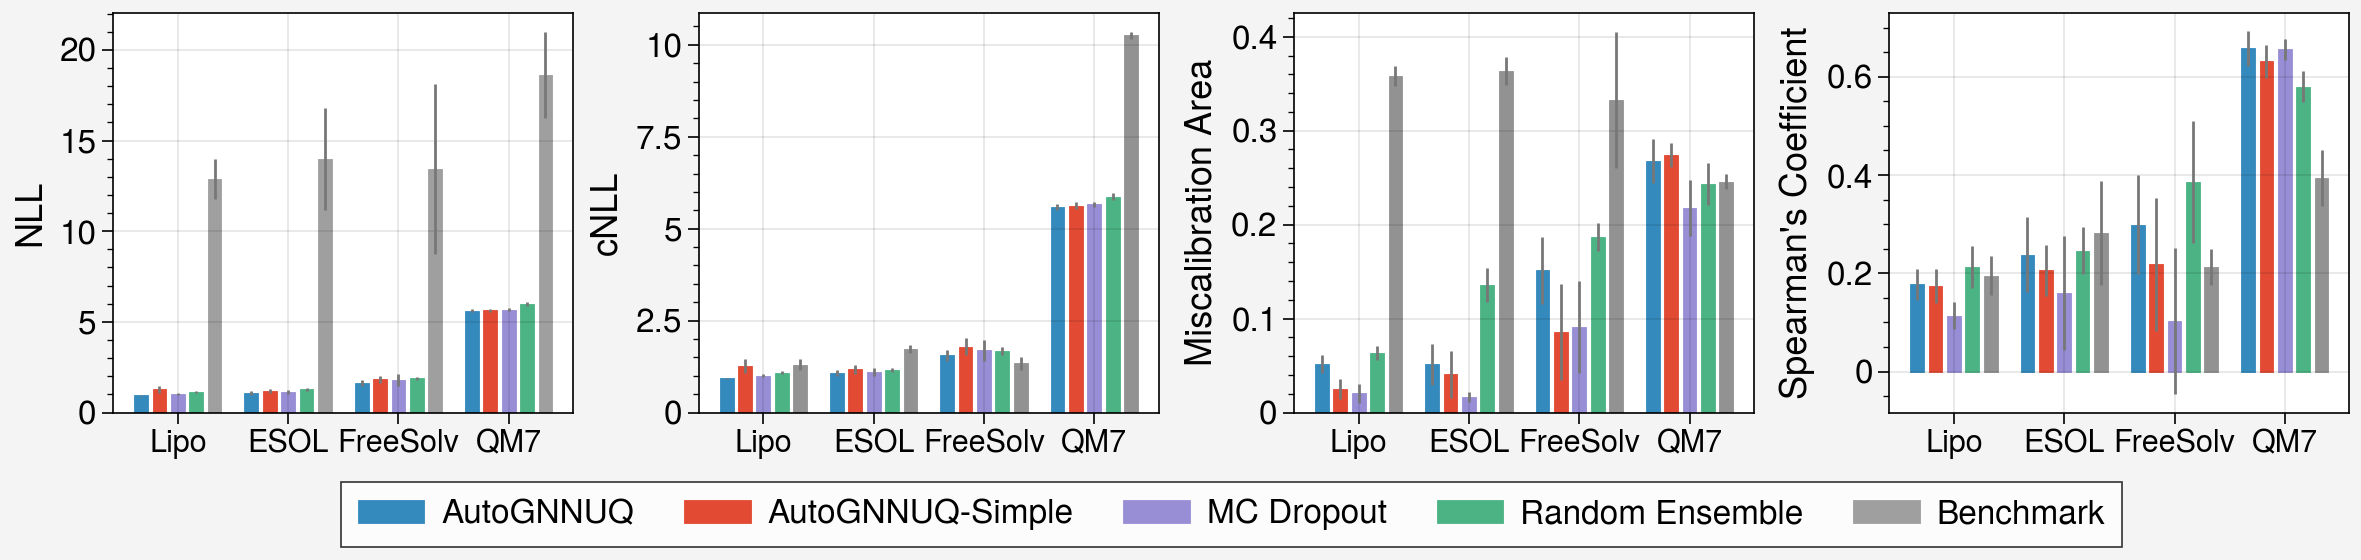

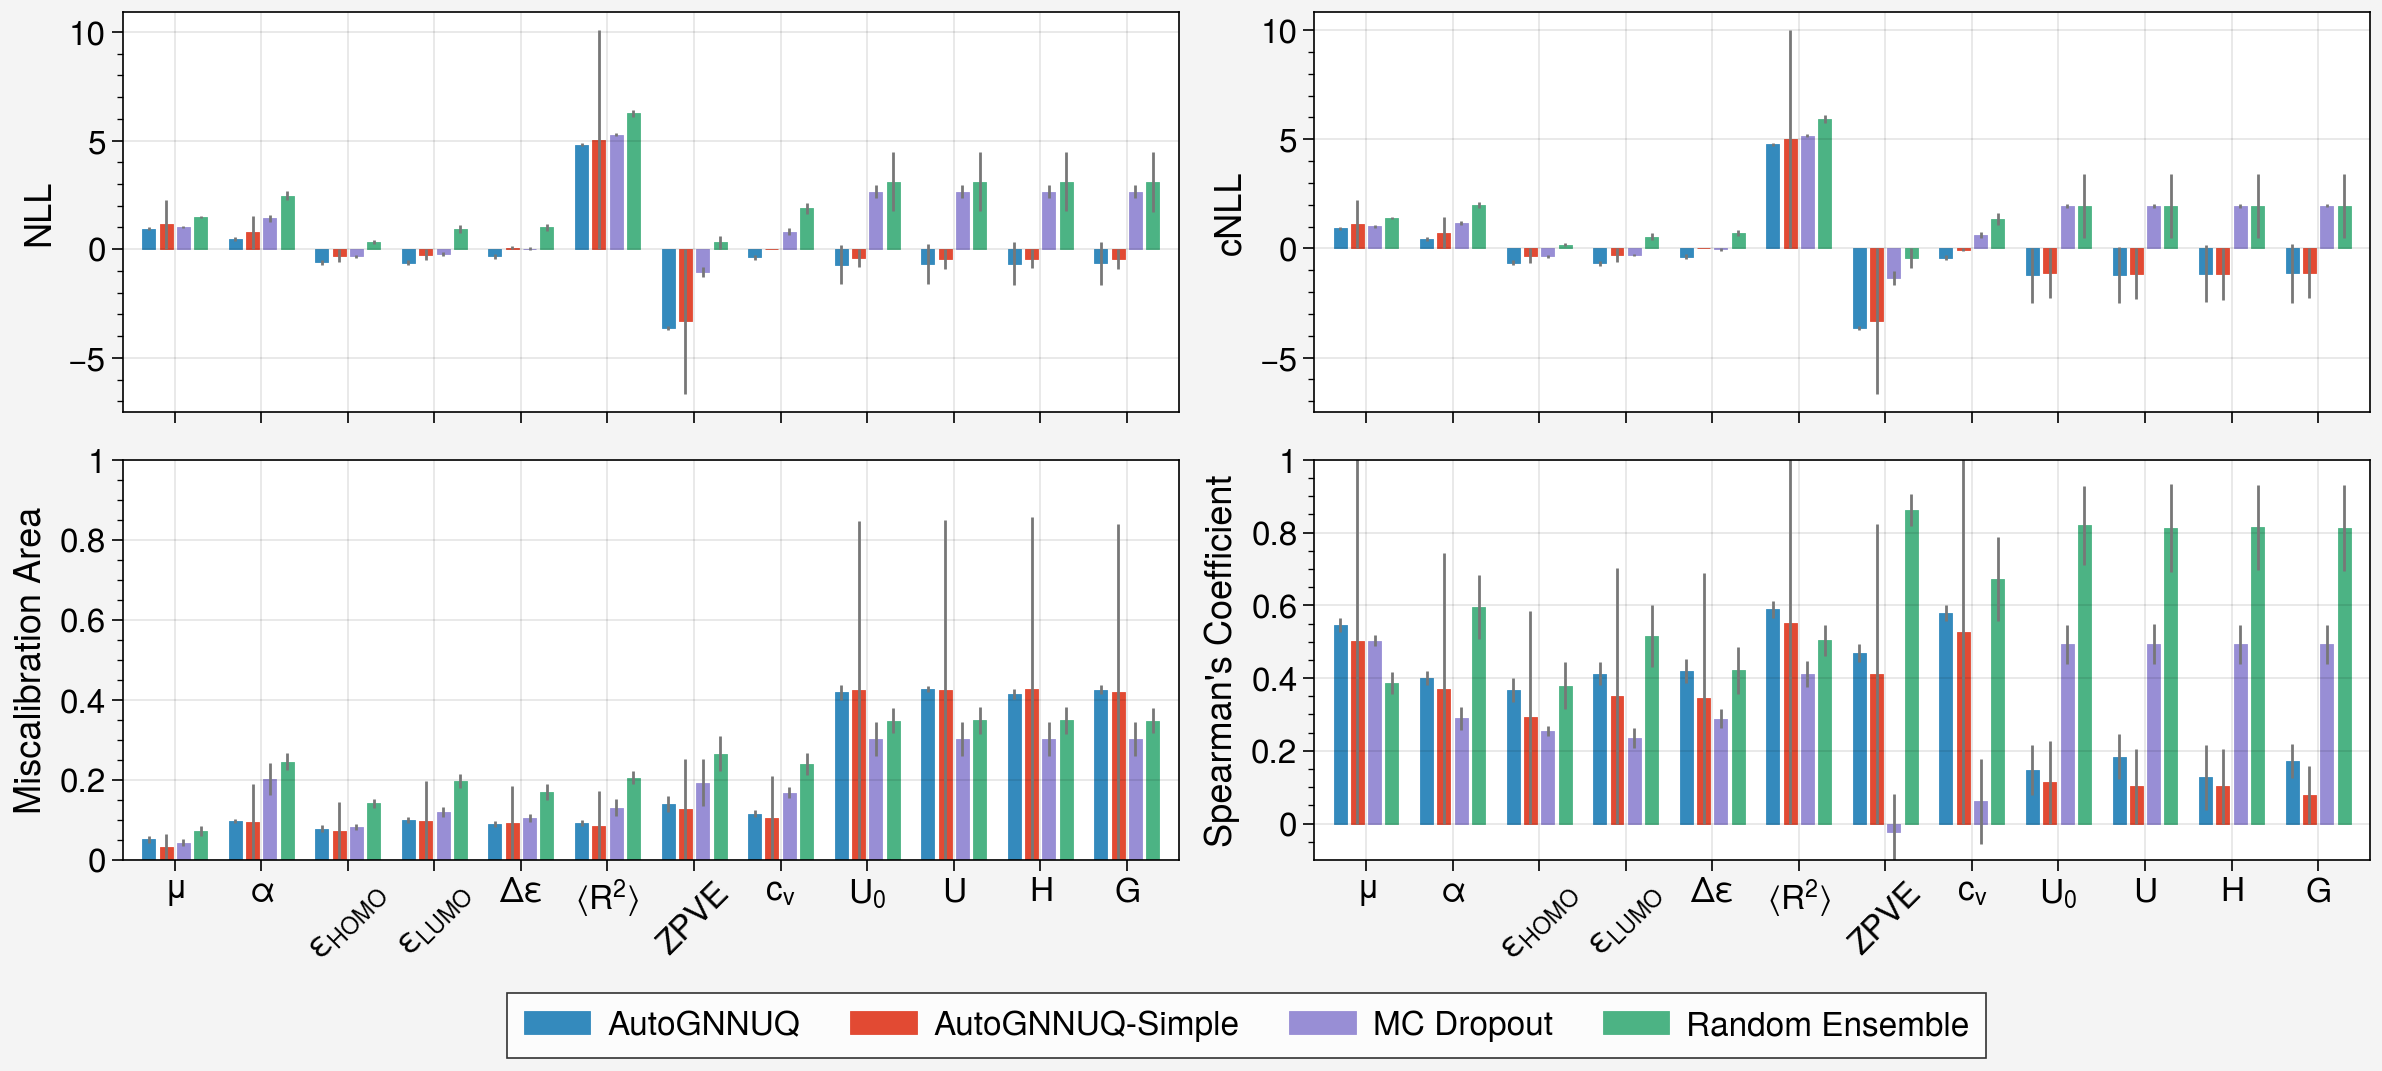

In [49]:
plot_uq_metrics(RESULT_DIR, PLOT_DIR, COLOR, format="pdf")

In [74]:
df = pd.read_csv("/scratch/gpfs/sj0161/autognnuq/NEW_RE_delaney_random_0_split_523/results.csv")

In [76]:
arch_min_ = df["p:arch_seq"][0]

In [79]:
id_min_ = df["job_id"][0]

In [80]:
id_min_

0

In [30]:
import pickle

In [36]:
with open("/scratch/gpfs/sj0161/autognnuq/result/val_test_result_random.pickle", "rb") as handle:
    o1 = pickle.load(handle)
    
with open("/scratch/gpfs/sj0161/autognn_backup/result/val_test_result_random.pickle", "rb") as handle:
    o2 = pickle.load(handle)

In [46]:
for i in range(8):

    print((o1[('lipo', '523', i)][3] == o2[('lipo', '523', i)][3]).all())

True
True
True
True
True
True
True
True


In [67]:
# from deephyper.gnn_uq.analysis.result_csv import result_to_csv_
# from deephyper.gnn_uq.analysis.result import combine_result
# import sklearn.metrics as skm
# result = o2

In [58]:
output = []

tasks = ["u0_atom", "lipo", "freesolv", "logSolubility"]
units = ["log D", "log mol/L", "kcal/mol", "kcal/mol"]

for i, dataset in enumerate(["lipo", "delaney", "freesolv", "qm7"]):
    metric_total = np.zeros(8)
    for seed in range(8):
        y_test_temp = np.copy(result[(dataset, "523", seed)][0])
        y_pred_temp = np.copy(result[(dataset, "523", seed)][1])

        if dataset == "qm7":
            metric_temp = skm.mean_absolute_error(y_test_temp, y_pred_temp)
            metric = "MAE"
        else:
            metric_temp = skm.mean_squared_error(y_test_temp, y_pred_temp) ** 0.5
            metric = "RMSE"

        metric_total[seed] = metric_temp

    nll, cnll, ma, sp = combine_result(result, dataset=dataset, SPLIT_TYPE="523")

    output.append(
        [
            dataset,
            tasks[i],
            units[i],
            metric_total.mean(),
            metric_total.std(),
            nll.mean(),
            nll.std(),
            cnll.mean(),
            cnll.std(),
            ma.mean(),
            ma.std(),
            sp.mean(),
            sp.std(),
        ]
    )
    
df = pd.DataFrame(
        output,
        columns=[
            "dataset",
            "task",
            "unit",
            "err_mean",
            "err_std",
            "nll_mean",
            "nll_std",
            "cnll_mean",
            "cnll_std",
            "ma_mean",
            "ma_std",
            "sp_mean",
            "sp_std",
        ],
    )

In [5]:

df = pd.read_csv(os.path.join(RESULT_DIR, "metrics.csv"))
df_simple = pd.read_csv(os.path.join(RESULT_DIR, "metrics_simple.csv"))
df_random = pd.read_csv(os.path.join(RESULT_DIR, "metrics_random.csv"))
df_mc = pd.read_csv(os.path.join(RESULT_DIR, "metrics_mc.csv"))

In [61]:
df_mc

dataset           task       unit   err_mean   err_std  nll_mean  \
0       lipo        u0_atom      log D   0.674813  0.030613  1.017339   
1    delaney           lipo  log mol/L   0.758878  0.061704  1.116112   
2   freesolv       freesolv   kcal/mol   1.333840  0.298615  1.805558   
3        qm7  logSolubility   kcal/mol  49.921192  3.875913  5.673565   
4        qm9             mu          D   0.617553  0.040293  1.020999   
5        qm9          alpha      a_0^3   0.626299  0.040554  1.424419   
6        qm9           homo         eV   0.138097  0.008999 -0.329904   
7        qm9           lumo         eV   0.144536  0.008273 -0.218717   
8        qm9            gap         eV   0.192035  0.012414  0.021506   
9        qm9             r2      a_0^2  37.087645  1.883160  5.276264   
10       qm9           zpve         eV   0.051413  0.013212 -1.038068   
11       qm9             cv  cal/mol K   0.348511  0.035964  0.796385   
12       qm9             u0   kcal/mol   1.514828  0.164180  2.641291   
13       qm9           u298   kcal/mol   1.515471  0.164084  2.641314   
14       qm9           h298   kcal/mol   1.514029  0.165583  2.640919   
15       qm9           g298   kcal/mol   1.514445  0.164546  2.641251   

     nll_std  cnll_mean  cnll_std   ma_mean    ma_std   sp_mean    sp_std  
0   0.048931   1.004565  0.038705  0.020296  0.010113  0.114010  0.027830  
1   0.105030   1.101177  0.113671  0.016863  0.005183  0.159964  0.116482  
2   0.336699   1.687289  0.280085  0.090884  0.049312  0.102824  0.148982  
3   0.075716   5.660117  0.074809  0.217463  0.030053  0.655962  0.021292  
4   0.065921   1.006722  0.065258  0.042890  0.009183  0.502984  0.014387  
5   0.154850   1.148576  0.091570  0.201859  0.040633  0.289113  0.032634  
6   0.072313  -0.369462  0.067654  0.081518  0.007207  0.254734  0.013100  
7   0.074419  -0.311789  0.057532  0.120750  0.012457  0.234325  0.027124  
8   0.075452  -0.047495  0.068414  0.104364  0.010800  0.288531  0.026391  
9   0.085327   5.164257  0.066220  0.130982  0.021127  0.410818  0.035034  
10  0.229785  -1.356987  0.317682  0.192968  0.058036 -0.022728  0.103834  
11  0.155980   0.598867  0.141345  0.168097  0.013551  0.060746  0.118095  
12  0.301151   1.943532  0.088445  0.301716  0.042458  0.493047  0.054076  
13  0.301208   1.943805  0.088554  0.301677  0.042412  0.493016  0.054407  
14  0.302294   1.942713  0.089967  0.301775  0.042356  0.492935  0.054071  
15  0.301306   1.951741  0.068859  0.301796  0.042334  0.492853  0.054297

In [6]:
order = []
for i in range(16):
    a = [df["nll_mean"][i], df_simple["nll_mean"][i], df_mc["nll_mean"][i], df_random["nll_mean"][i]]
    print(a)
    print(np.argsort(a))
    order.append(np.argsort(a))
    
order = np.array(order)


[0.9421686815944812, 1.268731468750845, 1.0173389583827035, 1.1205594151908975]
[0 2 3 1]
[1.0789084363664954, 1.1845815887953228, 1.116112328948263, 1.2849306352947194]
[0 2 1 3]
[1.6420560013390506, 1.8305516177651608, 1.8055576192027385, 1.8945649099733048]
[0 2 1 3]
[5.62461536042691, 5.642377037360656, 5.673564787329841, 5.968869401883866]
[0 1 2 3]
[0.9457400069701238, 1.137230026219439, 1.0209992779199717, 1.4643074789522197]
[0 2 1 3]
[0.4624756896729425, 0.7717260887034749, 1.4244188815490797, 2.4651785791288963]
[0 1 2 3]
[-0.6120320217265927, -0.3031033840444631, -0.3299035032108719, 0.3408606679029566]
[0 2 1 3]
[-0.6251004977417733, -0.255926025151539, -0.2187172319691551, 0.9134551402133266]
[0 1 2 3]
[-0.3193778096143247, 0.0623700453731969, 0.021506481560709, 0.9988707575254112]
[0 2 1 3]
[4.806289148828856, 5.044765030253496, 5.276264141274407, 6.250696345990675]
[0 1 2 3]
[-3.6256965971491386, -3.3234449381579148, -1.0380679849792274, 0.3086747381016682]
[0 1 2 3]
[-0

In [84]:
np.where(order == 1)[1].mean() + 1

2.4375

In [101]:
import sklearn.metrics as skm
from deephyper.gnn_uq.analysis import combine_result
file_simple = os.path.join(RESULT_DIR, "val_test_result_qm9_simple.pickle")

with open(file_simple, "rb") as handle:
    RESULT_QM9 = pickle.load(handle)

output = []
    
dataset = "qm9"

tasks = [
    "mu",
    "alpha",
    "homo",
    "lumo",
    "gap",
    "r2",
    "zpve",
    "cv",
    "u0",
    "u298",
    "h298",
    "g298",
]

units = [
    "D",
    "a_0^3",
    "eV",
    "eV",
    "eV",
    "a_0^2",
    "eV",
    "cal/mol K",
    "kcal/mol",
    "kcal/mol",
    "kcal/mol",
    "kcal/mol",
]

# unit bohr = a_0, 1 hartree = 27.2114 eV

for i, task in enumerate(tasks):
    metric_total = np.zeros(8)

    for seed in range(8):
        y_test_temp = np.copy(RESULT_QM9[(dataset, "811", seed)][0][:, i])
        y_pred_temp = np.copy(RESULT_QM9[(dataset, "811", seed)][1][:, i])

        if task in ["homo", "lumo", "gap", "zpve"]:
            y_test_temp *= 27.2114
            y_pred_temp *= 27.2114
        metric_temp = skm.mean_absolute_error(y_test_temp, y_pred_temp)
        metric_total[seed] = metric_temp

    nll, cnll, ma, sp = combine_result(
        RESULT_QM9, dataset=dataset, SPLIT_TYPE="811", idx=i
    )

    output.append(
        [
            dataset,
            tasks[i],
            units[i],
            metric_total.mean(),
            metric_total.std(),
            nll.mean(),
            nll.std(),
            cnll.mean(),
            cnll.std(),
            ma.mean(),
            ma.std(),
            sp.mean(),
            sp.std(),
        ]
    )
    print(nll)

df = pd.DataFrame(
    output,
    columns=[
        "dataset",
        "task",
        "unit",
        "err_mean",
        "err_std",
        "nll_mean",
        "nll_std",
        "cnll_mean",
        "cnll_std",
        "ma_mean",
        "ma_std",
        "sp_mean",
        "sp_std",
    ],
)

[1.13227624 1.1013558  1.28379736 0.98649357 1.23392581 1.26786433
 1.09934574 0.99278136]
[0.69216617 0.70317084 1.01009508 0.55943917 0.89991642 0.91947651
 0.86037878 0.52916575]
[-0.3499158  -0.37887178 -0.06738094 -0.48962195 -0.16286504 -0.12912808
 -0.33872031 -0.50832316]
[-0.31481937 -0.39513928  0.02269846 -0.48497325 -0.06415882 -0.0423737
 -0.29793293 -0.47070932]
[ 0.00668802 -0.07435715  0.35057202 -0.16667507  0.24428491  0.28596765
  0.02773348 -0.1752535 ]
[5.00289923 4.97878187 5.27292545 4.8864436  5.18729004 5.19014603
 4.9472816  4.89235241]
[-3.36954023 -3.42852676 -3.09277106 -3.3430162  -3.26727117 -3.2122667
 -3.35587123 -3.51829615]
[-0.06696733 -0.11590775  0.31148393 -0.16675229  0.15054644  0.18856535
 -0.05252887 -0.23824958]
[-0.8161248  -0.64536409 -1.01525574 -0.59440182 -0.96244967 -0.99674559
  1.47088729  0.27952602]
[-0.82156585 -0.64914208 -1.02901212 -0.57726153 -0.99622425 -1.02966294
  1.37542943  0.16530974]
[-0.80169894 -0.62851542 -1.00003938

In [100]:
nll

array([-0.83807862, -0.64222274, -1.0323037 , -0.59102449, -0.96578623,
       -0.99089819,  1.25943865,  0.18377247])

In [7]:
order = []
for i in range(16):
    a = [df["cnll_mean"][i], df_simple["cnll_mean"][i], df_mc["cnll_mean"][i], df_random["cnll_mean"][i]]
    print(a)
    print(np.argsort(a))
    order.append(np.argsort(a))
    
order = np.array(order)

[0.9253186435547684, 1.2642929462891426, 1.0045648439024637, 1.0793737920534716]
[0 2 3 1]
[1.0730850160066374, 1.1725707368832714, 1.1011767346180994, 1.146816827400408]
[0 2 3 1]
[1.556198454672789, 1.787534770568567, 1.6872887892516362, 1.67392866861243]
[0 3 2 1]
[5.589336804303805, 5.622671725644707, 5.660116825489379, 5.87001409421852]
[0 1 2 3]
[0.9214689598892164, 1.1196379994799148, 1.006722325457884, 1.3938312450204184]
[0 2 1 3]
[0.4189401188986285, 0.7285510891211657, 1.148575862456365, 1.993066263710692]
[0 1 2 3]
[-0.6527903683709304, -0.3435762424856746, -0.3694621862841879, 0.1674892547555876]
[0 2 1 3]
[-0.6846872316700686, -0.3201500409890275, -0.3117886918101405, 0.5382224826353186]
[0 1 2 3]
[-0.3728485118292353, 0.005246517455334, -0.047494994765776, 0.7224142012222675]
[0 2 1 3]
[4.767909207970296, 5.000790366785245, 5.164257234349914, 5.91960856210844]
[0 1 2 3]
[-3.6256965971491386, -3.3234449381579148, -1.3569868704740755, -0.4306383033721574]
[0 1 2 3]
[-0.436

In [12]:
np.where(order == 3)[1].mean() + 1

3.5

In [13]:
def benchmark_result(RESULT_DIR, dataset, estimator):
    benchmark = pd.read_csv(os.path.join(RESULT_DIR, "benchmark_result.csv"))
    benchmark = benchmark[
        (benchmark["Data Set"] == dataset)
        & (benchmark["Estimator"] == estimator)
        & (benchmark["Split"] == "Random Split")
    ]
    return benchmark



ref_nll = np.zeros((4, 8))
ref_cnll = np.zeros((4, 8))
ref_ma = np.zeros((4, 8))
ref_sp = np.zeros((4, 8))

datasets = ["lipo", "freesolv", "Delaney", "QM7"]

metrics = {
    "Average NLL": ref_nll,
    "Average Calibrated NLL": ref_cnll,
    "Miscalibration Area": ref_ma,
    "Spearman's Coefficient": ref_sp,
}

for index, dataset in enumerate(datasets):
    results = benchmark_result(
        RESULT_DIR=RESULT_DIR, dataset=dataset, estimator="MPNN Ensemble"
    )
    for metric, array in metrics.items():
        array[index] = results[metric]
        


ref_nll = metrics["Average NLL"]
ref_cnll = metrics["Average Calibrated NLL"]
ref_ma = metrics["Miscalibration Area"]
ref_sp = metrics["Spearman's Coefficient"]

In [16]:
ref_cnll.mean(axis=1)

array([ 1.29716444,  1.72957447,  1.33312689, 10.25789789])

In [17]:
(1.0730850160066374 - 1.72957447) / 1.72957447

-0.37956703534908365

In [18]:
order = []
for i in range(16):
    a = [df["ma_mean"][i], df_simple["ma_mean"][i], df_mc["ma_mean"][i], df_random["ma_mean"][i]]
    print(a)
    print(np.argsort(a))
    order.append(np.argsort(a))
    
order = np.array(order)

[0.0515055555555555, 0.0249339285714285, 0.0202956349206349, 0.0634720238095238]
[2 1 0 3]
[0.0514938790560471, 0.0408414454277286, 0.0168629056047197, 0.1360869469026548]
[2 1 0 3]
[0.1512247409326425, 0.0853062176165803, 0.0908839378238342, 0.1866709844559585]
[1 2 0 3]
[0.2675462908735969, 0.2740629941434846, 0.2174627623230844, 0.2432157271839922]
[2 3 0 1]
[0.0520388005078796, 0.0319058312794084, 0.0428896650235267, 0.0728610239749047]
[1 2 0 3]
[0.0972796698782582, 0.0945735305101202, 0.2018592688027485, 0.2449324071999402]
[1 0 2 3]
[0.0779323511838076, 0.0718435842856076, 0.0815181305549331, 0.1421174098140264]
[1 0 2 3]
[0.0998151467622675, 0.0984496601687952, 0.1207497759354694, 0.1964138471879901]
[1 0 2 3]
[0.090289790126223, 0.0920889349465979, 0.1043644036149077, 0.1694049219508552]
[0 1 2 3]
[0.0921344013742624, 0.0858427627156621, 0.1309818694450668, 0.2053536485174397]
[1 0 2 3]
[0.1398087982672343, 0.1263202068862499, 0.1929683882291433, 0.2659519941743222]
[1 0 2 3]


In [22]:
for i in range(4):
    print(np.where(order == i)[1].mean() + 1)

2.625
2.0
2.0
3.375


In [26]:
order = []
for i in range(16):
    a = [df["sp_mean"][i], df_simple["sp_mean"][i], df_mc["sp_mean"][i], df_random["sp_mean"][i]]
    print(a)
    print(np.argsort(a)[::-1])
    order.append(np.argsort(a)[::-1])
    
order = np.array(order)

[0.1778356709303377, 0.1746662127917091, 0.1140097060013864, 0.2127831825650827]
[3 0 1 2]
[0.2381319902417688, 0.2062870207516425, 0.159964088113267, 0.2463115934439964]
[3 0 1 2]
[0.299135162384488, 0.217949386718124, 0.1028238258506489, 0.3853505922493456]
[3 0 1 2]
[0.657654265000625, 0.6309262281887209, 0.6559621991533273, 0.5792844629997791]
[0 2 1 3]
[0.5458786950306691, 0.5008596532478462, 0.5029841493634264, 0.3865898377993623]
[0 2 1 3]
[0.4003337695568043, 0.371318246804862, 0.2891126839420694, 0.5951482786156781]
[3 0 1 2]
[0.3670827418482155, 0.2927953207834506, 0.2547342790950033, 0.3790732528467682]
[3 0 1 2]
[0.4117799226886309, 0.3516192749934944, 0.2343254584270817, 0.5164382919914355]
[3 0 1 2]
[0.4198615316855444, 0.3446044724546168, 0.2885313733527126, 0.4220004944534468]
[3 0 1 2]
[0.5886224767812964, 0.5514589309400384, 0.4108181541761018, 0.504471390181878]
[0 1 3 2]
[0.4693141157856112, 0.4113208057288501, -0.0227284072560774, 0.861951775869614]
[3 0 1 2]
[0.58

In [27]:
for i in range(4):
    print(np.where(order == i)[1].mean() + 1)

2.0625
3.1875
3.25
1.5


In [31]:
def benchmark_result(dataset='Delaney', estimator='MPNN Ensemble'):
    benchmark = pd.read_csv('/scratch/gpfs/sj0161/autognnuq/data/benchmark_result.csv')
    benchmark = benchmark[
        (benchmark['Data Set'] == dataset) &
        (benchmark['Estimator'] == estimator) &
        (benchmark['Split'] == 'Random Split')
    ]
    return benchmark

In [77]:
import pickle

with open("/scratch/gpfs/sj0161/autognnuq/NEW_POST_RESULT_MC/post_result_delaney_random_0_split_523/test_903_0.pickle", "rb") as handle:
    y_true = pickle.load(handle)
    y_pred = pickle.load(handle)

In [78]:
from deephyper.gnn_uq.analysis import get_result_mc_dropout, combine_result, miscal_area

In [85]:
output = get_result_mc_dropout(ROOT_DIR=ROOT_DIR, DATA_DIR=DATA_DIR, datasets=["delaney"], split_types=["523"], range_seeds=[0,1,2,3,4,5,6,7])

In [104]:
for i in range(8):
    (y_test_temp,
    y_test_pred,
    y_test_epis,
    y_test_alea,
    y_val_temp,
    y_val_pred,
    y_val_epis,
    y_val_alea)=output[("delaney", "523", i)]

    print(miscal_area(y_test_epis + y_test_alea, y_test_pred, y_test_temp)[0])
    print(skm.mean_squared_error(y_test_pred, y_test_temp)**0.5)    

0.017999410029498522
0.7578602283343691
0.0270212389380531
0.6554103664906047
0.01361061946902655
0.7838562225104723
0.015131563421828913
0.7486288692322784
0.011332743362831861
0.8203242667008959
0.0232283185840708
0.671587988648561
0.012964601769911498
0.8384422111065248
0.013614749262536875
0.7949103365970991


In [103]:
import sklearn.metrics as skm

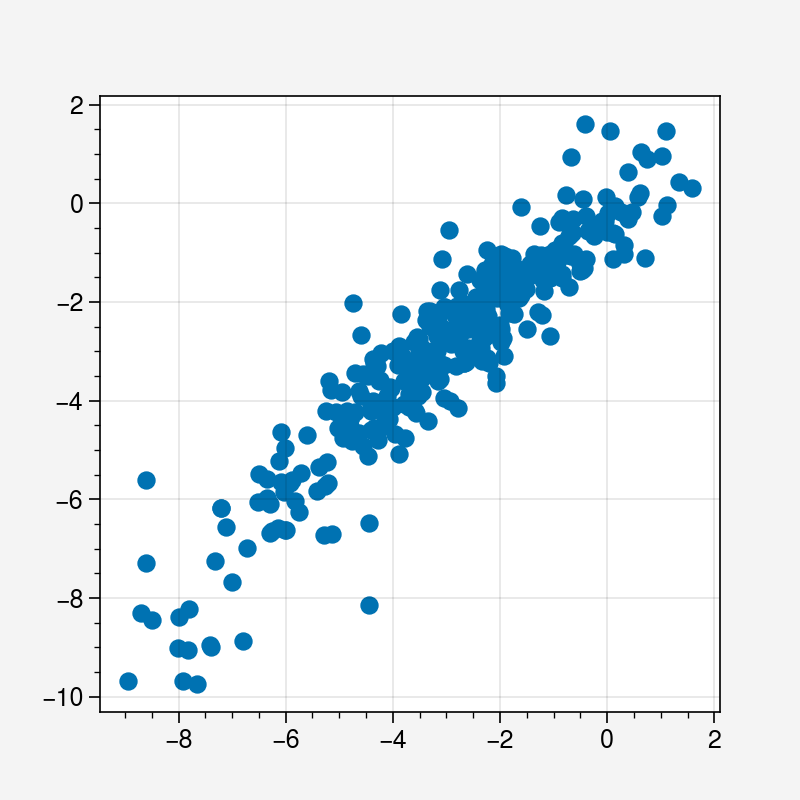

In [101]:
plt.scatter(y_test_temp, y_test_pred)

In [ ]:
fro

In [5]:
def conf_curve(err, unc, mode='rmse'):
    idx = np.argsort(-unc)
    
    err = err[idx]
    unc = unc[idx]
    
    cum_err = []

    percent = np.arange(0, 101, 1) 

    for p in percent:
        n = int(p * len(err) / 101)
        if mode == 'rmse':
            err_mean = np.mean(err[n:]**2) ** 0.5
        elif mode == 'mae':
            err_mean = np.mean(err[n:])
        cum_err.append(err_mean)

    return percent, np.array(cum_err)

def decreasing_coefficient(arr):
    if len(arr) < 2:
        return 0  # Return 0 or some appropriate value for arrays with less than 2 elements

    count = 0
    for i in range(1, len(arr)):
        if arr[i] < arr[i - 1]:
            count += 1

    return count / (len(arr) - 1)



LABELS = [
    "Lipo" + "\n" + "[log D]",
    "ESOL" + "\n" + "[log mol/L]",
    "FreeSolv" + "\n" + "[kcal/mol]",
    "QM7" + "\n" + "[kcal/mol]",
    r"QM9 $\mu$" + "\n" + "[D]",
    r"QM9 $\alpha$" + "\n" + r"[$a_0^3$]",
    r"QM9 $\epsilon_{\mathrm{HOMO}}$" + "\n" + "[eV]",
    r"QM9 $\epsilon_{\mathrm{LUMO}}$" + "\n" + "[eV]",
    r"QM9 $\Delta \epsilon$" + "\n" + "[eV]",
    r"QM9 $\langle R^2 \rangle$" + "\n" + r"[$a_0^2$]",
    r"QM9 ZPVE" + "\n" + "[eV]",
    r"QM9 $c_v$" + "\n" + "[cal/mol$\cdot$K]",
    r"QM9 $U_0$" + "\n" + "[kcal/mol]",
    r"QM9 $U$" + "\n" + "[kcal/mol]",
    r"QM9 $H$" + "\n" + "[kcal/mol]",
    r"QM9 $G$" + "\n" + "[kcal/mol]",
]





AUCO:
Total: 30.55 (1.75)
AUCO:
Total: 34.00 (8.98)
AUCO:
Total: 53.13 (10.23)
AUCO:
Total: 939.45 (63.19)
AUCO:
Total: 11.77 (1.10)
AUCO:
Total: 8.82 (0.95)
AUCO:
Total: 3.29 (0.52)
AUCO:
Total: 2.97 (0.50)
AUCO:
Total: 4.00 (0.72)
AUCO:
Total: 496.94 (64.98)
AUCO:
Total: 0.12 (0.01)
AUCO:
Total: 2.76 (0.45)
AUCO:
Total: 0.53 (0.14)
AUCO:
Total: 0.47 (0.06)
AUCO:
Total: 0.56 (0.07)
AUCO:
Total: 0.48 (0.06)


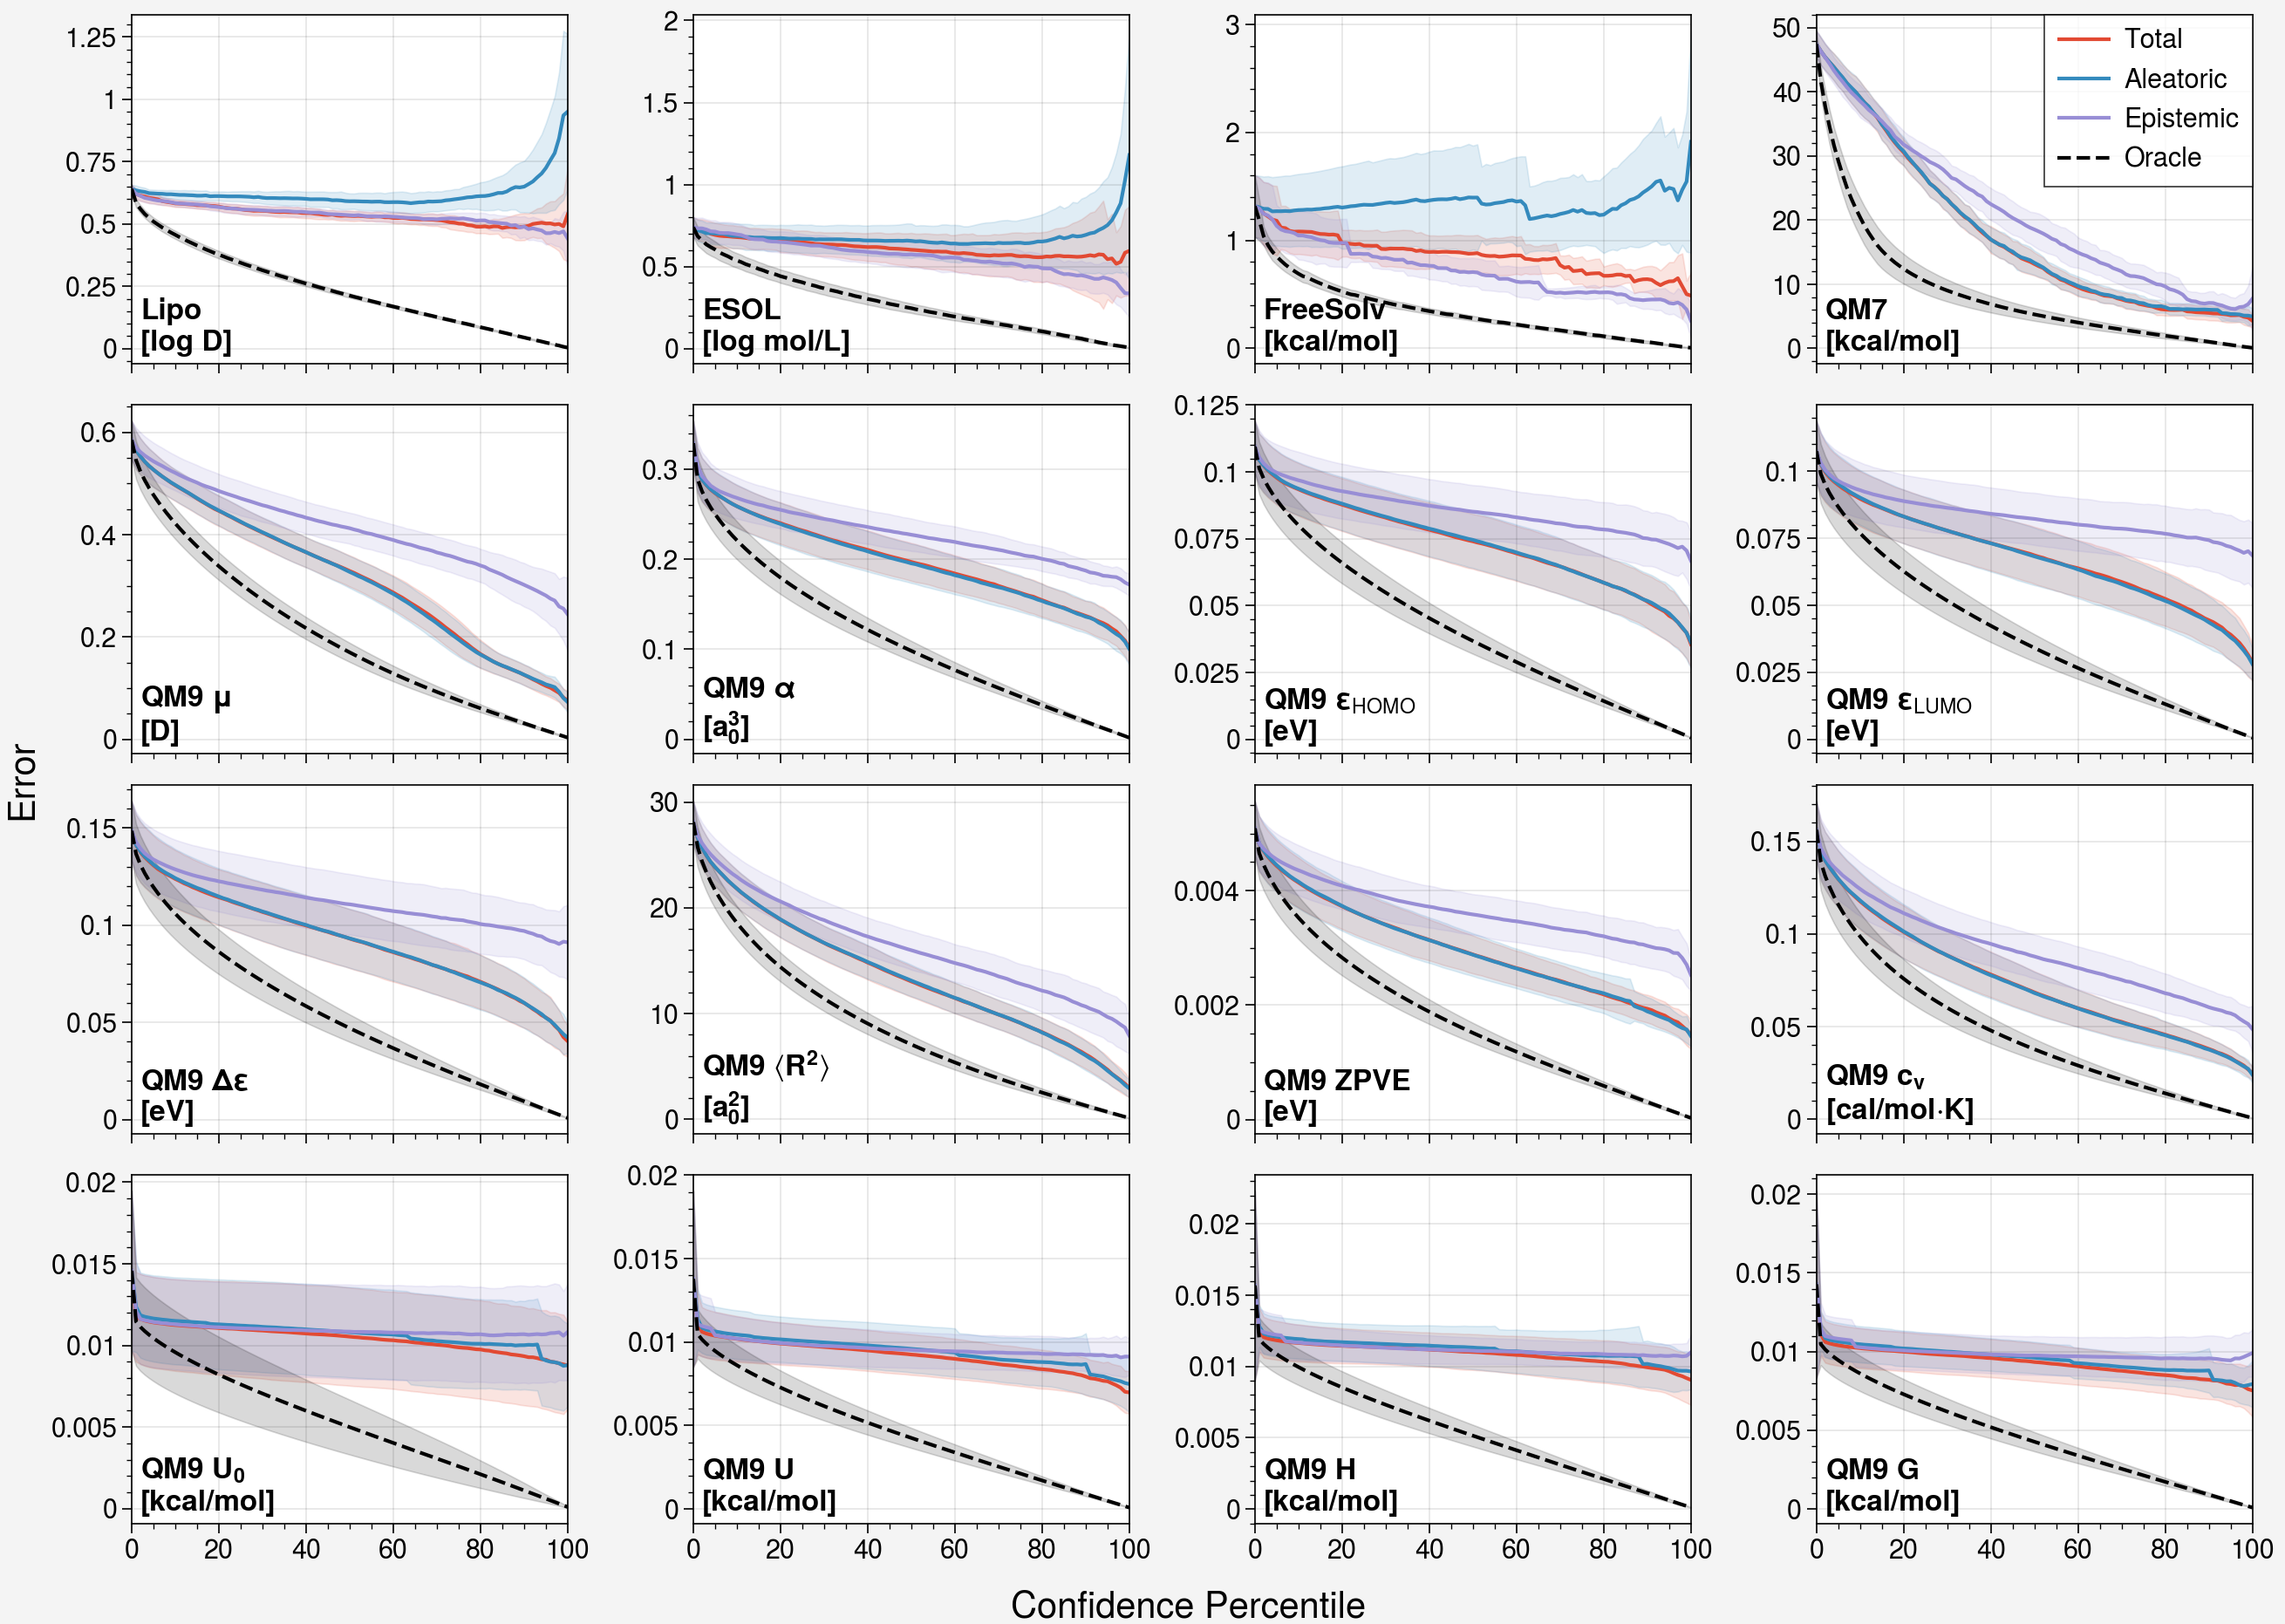

In [25]:
with open("/scratch/gpfs/sj0161/autognnuq/result/val_test_result.pickle", "rb") as handle:
    result = pickle.load(handle)
    
with open("/scratch/gpfs/sj0161/autognnuq/result/val_test_result_qm9.pickle", "rb") as handle:
    result_qm9 = pickle.load(handle)

fig, ax = pplt.subplots(refheight=2, refwidth=2.5, ncols=4, nrows=4, sharey=False)



for i in range(16):
    oracle = np.zeros((8, 101))
    err_ale = np.zeros((8, 101))
    err_epi = np.zeros((8, 101))
    err_tot = np.zeros((8, 101))

    if i == 0:
        dataset = "lipo"
    elif i == 1:
        dataset = "delaney"
    elif i == 2:
        dataset = "freesolv"
    elif i == 3:
        dataset = "qm7"
    else:
        dataset = "qm9"

    if i >= 3:
        mode = "mae"
        ylabel = "MAE"
    else:
        mode = "rmse"
        ylabel = "RMSE"

    for seed in range(8):
        if dataset == "qm9":
            split = "811"

            y_true, y_pred, y_epis, y_alea, v_true, v_pred, v_epis, v_alea = (
                result_qm9[dataset, split, seed]
            )
            y_true = np.copy(y_true)[..., i - 4]
            y_pred = np.copy(y_pred)[..., i - 4]
            y_alea = np.copy(y_alea)[..., i - 4]
            y_epis = np.copy(y_epis)[..., i - 4]

            if i in [6, 7, 8, 10]:
                y_true = y_true * 27.2114
                y_pred = y_pred * 27.2114
                y_alea = y_alea * (27.2114**2)
                y_epis = y_epis * (27.2114**2)

        else:
            split = "523"

            y_true, y_pred, y_epis, y_alea, v_true, v_pred, v_epis, v_alea = result[
                dataset, split, seed
            ]

        err = np.abs(y_true-y_pred)

        p, oracle[seed] = conf_curve(err, err, mode=mode)
        _, err_ale[seed] = conf_curve(err, y_alea ** 0.5, mode=mode)
        _, err_epi[seed] = conf_curve(err, y_epis ** 0.5, mode=mode)
        _, err_tot[seed] = conf_curve(err, (y_alea+y_epis) ** 0.5, mode=mode)


    ax[i].plot(p, err_tot.mean(axis=0), label="Total", c=COLOR[0])
    ax[i].fill_between(p,  
                    err_tot.mean(axis=0)-err_tot.std(axis=0),
                    err_tot.mean(axis=0)+err_tot.std(axis=0), c=COLOR[0], alpha=0.15)

    ax[i].plot(p, err_ale.mean(axis=0), label="Aleatoric", c=COLOR[1])
    ax[i].fill_between(p,  
                    err_ale.mean(axis=0)-err_ale.std(axis=0), 
                    err_ale.mean(axis=0)+err_ale.std(axis=0), c=COLOR[1], alpha=0.15)

    ax[i].plot(p, err_epi.mean(axis=0), label="Epistemic", c=COLOR[2])
    ax[i].fill_between(p,  
                    err_epi.mean(axis=0)-err_epi.std(axis=0), 
                    err_epi.mean(axis=0)+err_epi.std(axis=0), c=COLOR[2], alpha=0.15)

    ax[i].plot(p, oracle.mean(axis=0), 'k--', label="Oracle")

    ax[i].fill_between(p,  
                    oracle.mean(axis=0)-oracle.std(axis=0), 
                    oracle.mean(axis=0)+oracle.std(axis=0), c="#000000", alpha=0.15)

    ax[i].text(
        0.02,
        0.02,
        LABELS[i],
        ha="left",
        va="bottom",
        transform=ax[i].transAxes,
        fontsize=12,
        color="k",
        weight="bold",
    )
    

    ax[i].format(
        xlabelsize=14,
        ylabelsize=14,
        xticklabelsize=11,
        yticklabelsize=11,
        xlim=[0, 100],
    )

    if i == 3:
        ax[i].legend(ncol=1, loc="upper right", prop={"size": 11})
        
        
    err_cut = err_tot[:, [0, 50, 75, 90, 95]].mean(axis=0)
    err_cut_std = err_tot[:, [0, 50, 75, 90, 95]].std(axis=0) / (8 ** 0.5)

#     print(fr"{name:<10} {err_cut[0]:0.2f} ({err_cut_std[0]:0.2f}) & {err_cut[1]:0.2f} ({err_cut_std[1]:0.2f}) & {err_cut[2]:0.2f} ({err_cut_std[2]:0.2f}) & {err_cut[3]:0.2f} ({err_cut_std[3]:0.2f}) & {err_cut[4]:0.2f} ({err_cut_std[4]:0.2f})")
    

    # calculate auco, area under the confidence-oracle error
    print("AUCO:")
    print(f"Total: {(err_tot-oracle).sum(axis=1).mean():0.2f} ({(err_tot-oracle).sum(axis=1).std():0.2f})")
#     print(f"Aleatoric: {(err_ale-oracle).sum(axis=1).mean():0.2f} +/- {(err_ale-oracle).sum(axis=1).std():0.2f}")
#     print(f"Epistemic: {(err_epi-oracle).sum(axis=1).mean():0.2f} +/- {(err_epi-oracle).sum(axis=1).std():0.2f}")


    # calculate decreasing coeffcient
#     print()
#     print("Decreasing Coeffcient:")
#     print(f"Oracle: {np.mean([decreasing_coefficient(oracle[i]) for i in range(8)]):0.2f} +/- {np.std([decreasing_coefficient(oracle[i]) for i in range(8)]):0.2f}")
#     print(f"Total: {np.mean([decreasing_coefficient(err_tot[i]) for i in range(8)]):0.2f} +/- {np.std([decreasing_coefficient(err_tot[i]) for i in range(8)]):0.2f}")
#     print(f"Aleatoric: {np.mean([decreasing_coefficient(err_ale[i]) for i in range(8)]):0.2f} +/- {np.std([decreasing_coefficient(err_ale[i]) for i in range(8)]):0.2f}")
#     print(f"Epistemic: {np.mean([decreasing_coefficient(err_epi[i]) for i in range(8)]):0.2f} +/- {np.std([decreasing_coefficient(err_epi[i]) for i in range(8)]):0.2f}")

#     name = LABELS[i].split('\n')[0]
    

fig.text(
    0.01,
    0.52,
    "Error",
    va="center",
    ha="center",
    rotation="vertical",
    fontsize=15,
    transform=fig.transFigure
)
fig.text(
    0.52,
    0.01,
    "Confidence Percentile",
    va="center",
    ha="center",
    rotation=0,
    fontsize=15,
    transform=fig.transFigure,
)


out_file = os.path.join(PLOT_DIR, f"conf_cutoff.pdf")

fig.save(out_file, bbox_inches="tight", dpi=600)

AUCO:
Total: 42.06 (6.92)
AUCO:
Total: 37.46 (10.96)
AUCO:
Total: 66.41 (18.86)
AUCO:
Total: 989.97 (86.88)
AUCO:
Total: 15.87 (2.70)
AUCO:
Total: 12.48 (2.22)
AUCO:
Total: 5.13 (1.14)
AUCO:
Total: 4.88 (1.09)
AUCO:
Total: 6.81 (1.84)
AUCO:
Total: 684.88 (145.02)
AUCO:
Total: 0.19 (0.04)
AUCO:
Total: 4.62 (1.33)
AUCO:
Total: 0.72 (0.10)
AUCO:
Total: 0.73 (0.10)
AUCO:
Total: 0.72 (0.10)
AUCO:
Total: 0.79 (0.16)


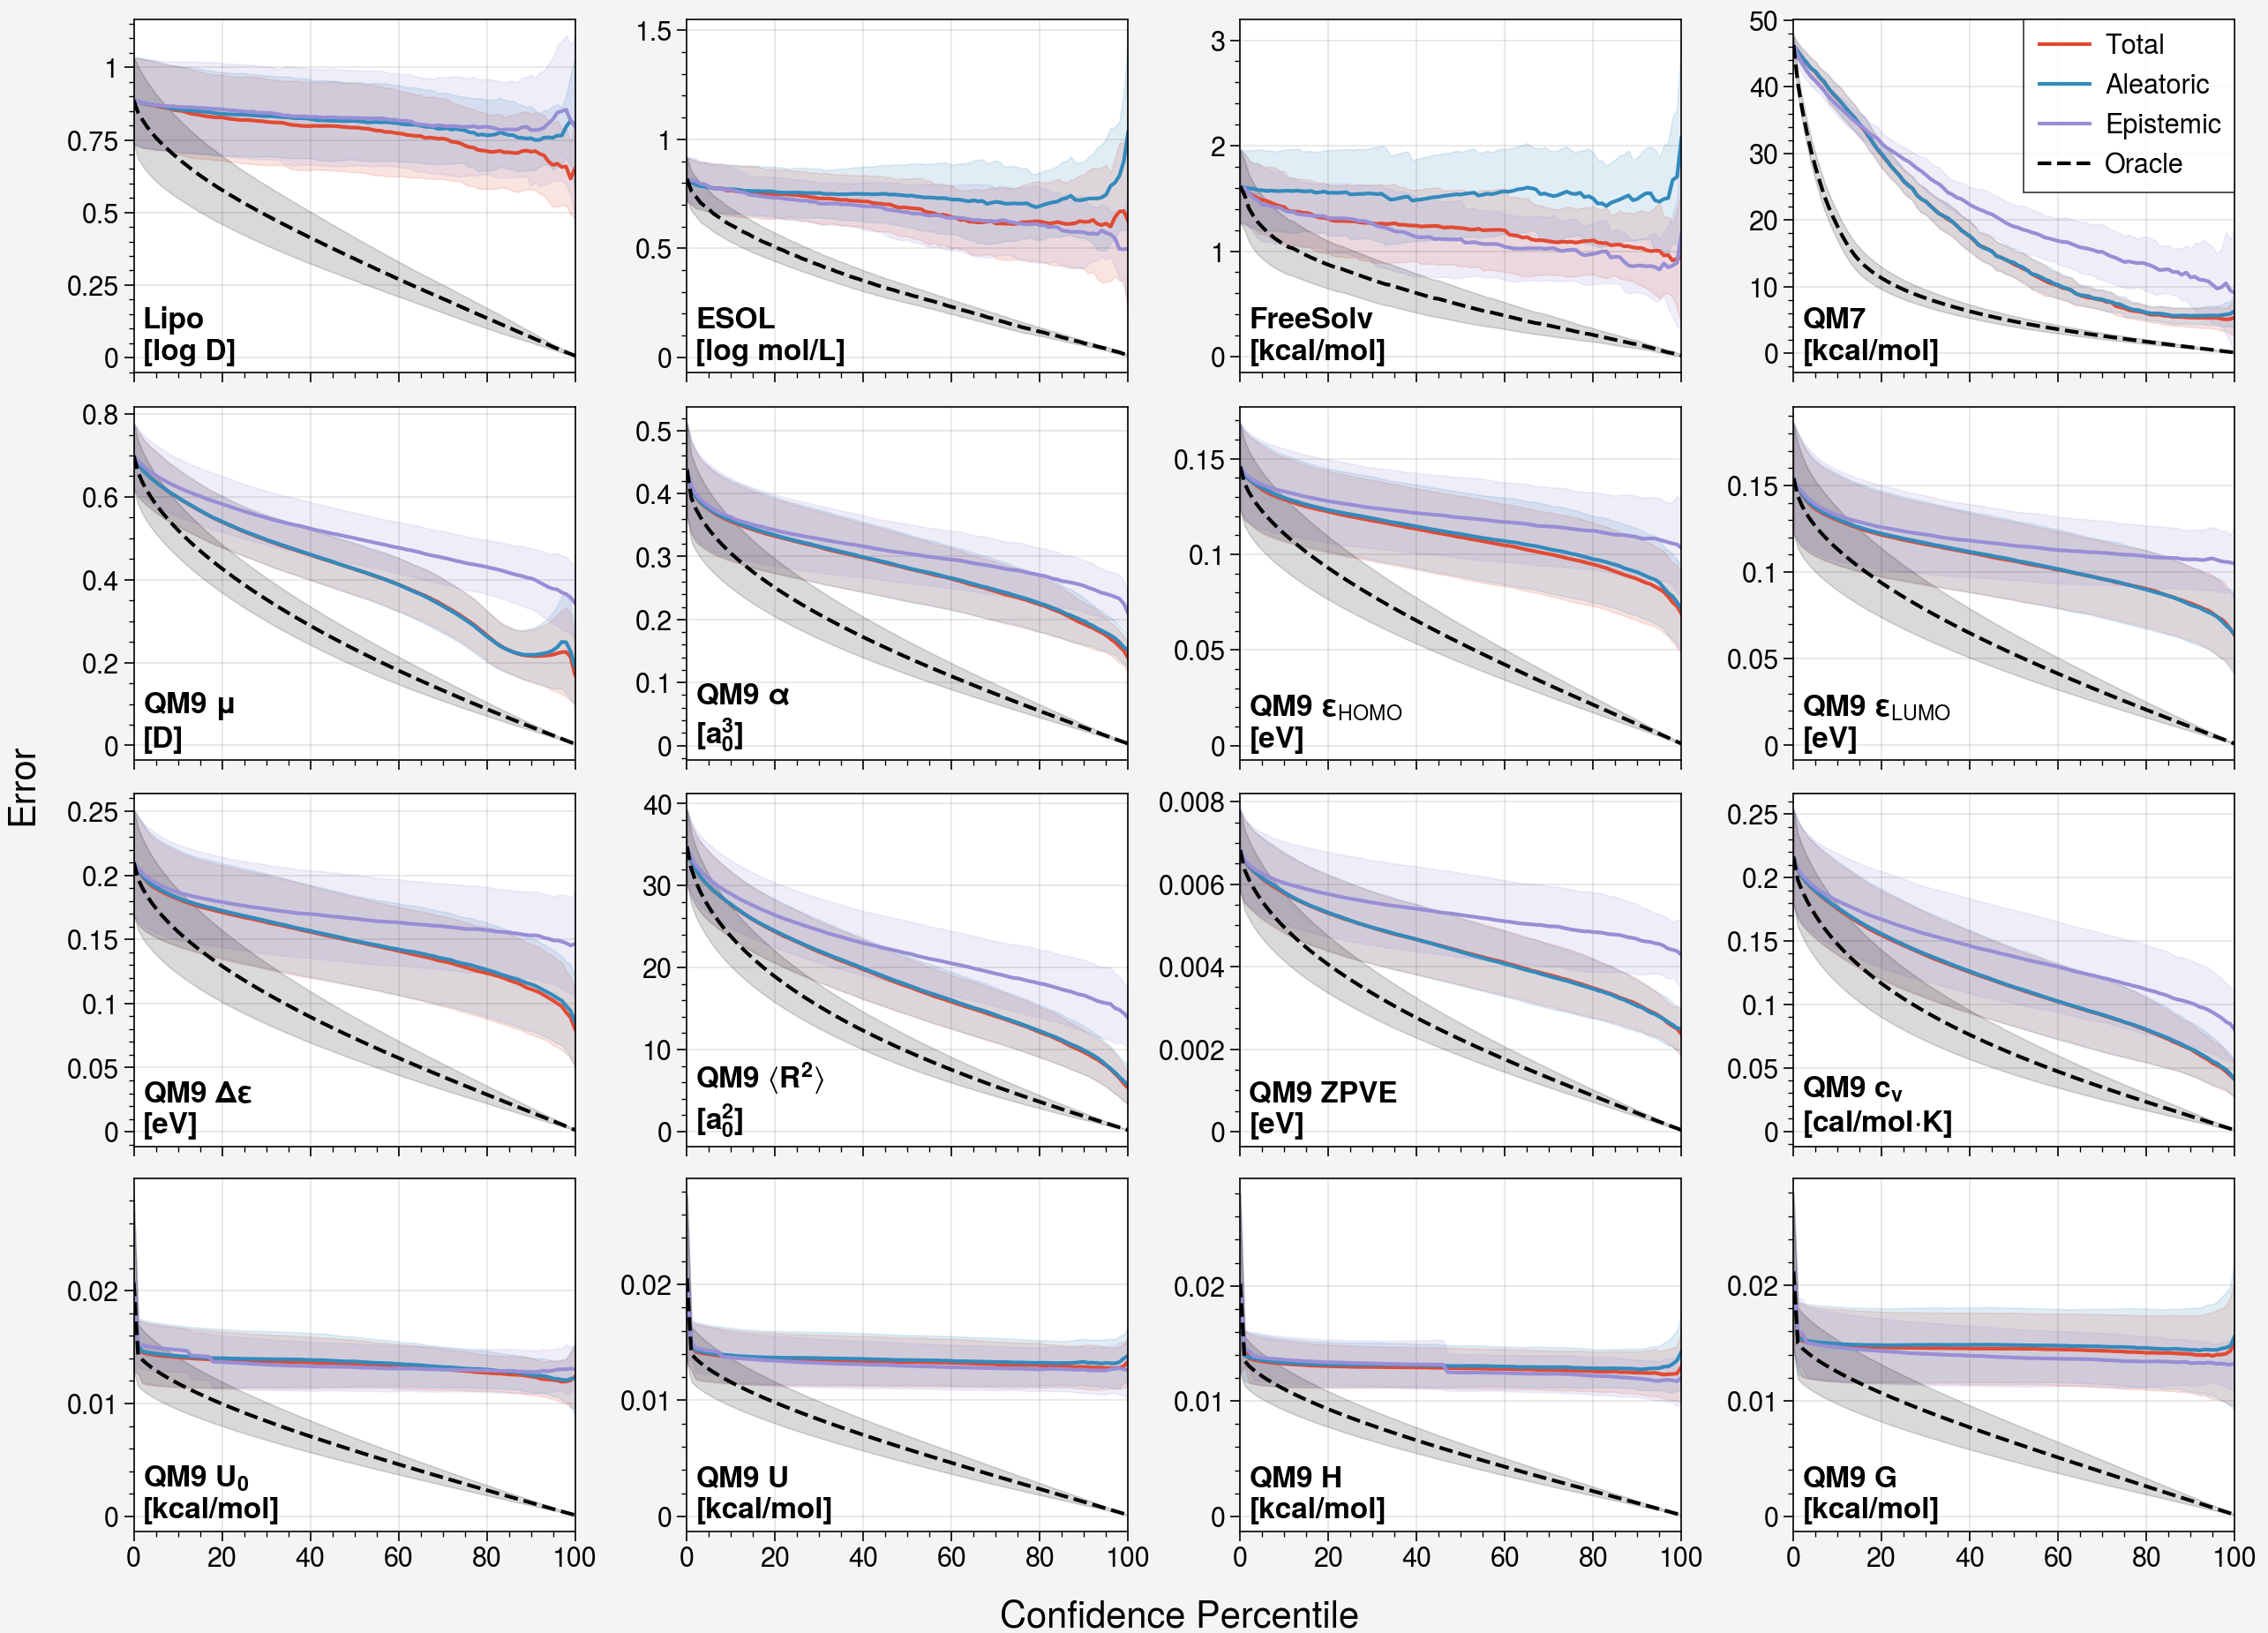

In [27]:
with open("/scratch/gpfs/sj0161/autognnuq/result/val_test_result_simple.pickle", "rb") as handle:
    result = pickle.load(handle)
    
with open("/scratch/gpfs/sj0161/autognnuq/result/val_test_result_qm9_simple.pickle", "rb") as handle:
    result_qm9 = pickle.load(handle)

fig, ax = pplt.subplots(refheight=2, refwidth=2.5, ncols=4, nrows=4, sharey=False)



for i in range(16):
    oracle = np.zeros((8, 101))
    err_ale = np.zeros((8, 101))
    err_epi = np.zeros((8, 101))
    err_tot = np.zeros((8, 101))

    if i == 0:
        dataset = "lipo"
    elif i == 1:
        dataset = "delaney"
    elif i == 2:
        dataset = "freesolv"
    elif i == 3:
        dataset = "qm7"
    else:
        dataset = "qm9"

    if i >= 3:
        mode = "mae"
        ylabel = "MAE"
    else:
        mode = "rmse"
        ylabel = "RMSE"

    for seed in range(8):
        if dataset == "qm9":
            split = "811"

            y_true, y_pred, y_epis, y_alea, v_true, v_pred, v_epis, v_alea = (
                result_qm9[dataset, split, seed]
            )
            y_true = np.copy(y_true)[..., i - 4]
            y_pred = np.copy(y_pred)[..., i - 4]
            y_alea = np.copy(y_alea)[..., i - 4]
            y_epis = np.copy(y_epis)[..., i - 4]

            if i in [6, 7, 8, 10]:
                y_true = y_true * 27.2114
                y_pred = y_pred * 27.2114
                y_alea = y_alea * (27.2114**2)
                y_epis = y_epis * (27.2114**2)

        else:
            split = "523"

            y_true, y_pred, y_epis, y_alea, v_true, v_pred, v_epis, v_alea = result[
                dataset, split, seed
            ]

        err = np.abs(y_true-y_pred)

        p, oracle[seed] = conf_curve(err, err, mode=mode)
        _, err_ale[seed] = conf_curve(err, y_alea ** 0.5, mode=mode)
        _, err_epi[seed] = conf_curve(err, y_epis ** 0.5, mode=mode)
        _, err_tot[seed] = conf_curve(err, (y_alea+y_epis) ** 0.5, mode=mode)


    ax[i].plot(p, err_tot.mean(axis=0), label="Total", c=COLOR[0])
    ax[i].fill_between(p,  
                    err_tot.mean(axis=0)-err_tot.std(axis=0),
                    err_tot.mean(axis=0)+err_tot.std(axis=0), c=COLOR[0], alpha=0.15)

    ax[i].plot(p, err_ale.mean(axis=0), label="Aleatoric", c=COLOR[1])
    ax[i].fill_between(p,  
                    err_ale.mean(axis=0)-err_ale.std(axis=0), 
                    err_ale.mean(axis=0)+err_ale.std(axis=0), c=COLOR[1], alpha=0.15)

    ax[i].plot(p, err_epi.mean(axis=0), label="Epistemic", c=COLOR[2])
    ax[i].fill_between(p,  
                    err_epi.mean(axis=0)-err_epi.std(axis=0), 
                    err_epi.mean(axis=0)+err_epi.std(axis=0), c=COLOR[2], alpha=0.15)

    ax[i].plot(p, oracle.mean(axis=0), 'k--', label="Oracle")

    ax[i].fill_between(p,  
                    oracle.mean(axis=0)-oracle.std(axis=0), 
                    oracle.mean(axis=0)+oracle.std(axis=0), c="#000000", alpha=0.15)

    ax[i].text(
        0.02,
        0.02,
        LABELS[i],
        ha="left",
        va="bottom",
        transform=ax[i].transAxes,
        fontsize=12,
        color="k",
        weight="bold",
    )
    

    ax[i].format(
        xlabelsize=14,
        ylabelsize=14,
        xticklabelsize=11,
        yticklabelsize=11,
        xlim=[0, 100],
    )

    if i == 3:
        ax[i].legend(ncol=1, loc="upper right", prop={"size": 11})
        
        
    err_cut = err_tot[:, [0, 50, 75, 90, 95]].mean(axis=0)
    err_cut_std = err_tot[:, [0, 50, 75, 90, 95]].std(axis=0) / (8 ** 0.5)

#     print(fr"{name:<10} {err_cut[0]:0.2f} ({err_cut_std[0]:0.2f}) & {err_cut[1]:0.2f} ({err_cut_std[1]:0.2f}) & {err_cut[2]:0.2f} ({err_cut_std[2]:0.2f}) & {err_cut[3]:0.2f} ({err_cut_std[3]:0.2f}) & {err_cut[4]:0.2f} ({err_cut_std[4]:0.2f})")
    

    # calculate auco, area under the confidence-oracle error
    print("AUCO:")
    print(f"Total: {(err_tot-oracle).sum(axis=1).mean():0.2f} ({(err_tot-oracle).sum(axis=1).std():0.2f})")
#     print(f"Aleatoric: {(err_ale-oracle).sum(axis=1).mean():0.2f} +/- {(err_ale-oracle).sum(axis=1).std():0.2f}")
#     print(f"Epistemic: {(err_epi-oracle).sum(axis=1).mean():0.2f} +/- {(err_epi-oracle).sum(axis=1).std():0.2f}")


    # calculate decreasing coeffcient
#     print()
#     print("Decreasing Coeffcient:")
#     print(f"Oracle: {np.mean([decreasing_coefficient(oracle[i]) for i in range(8)]):0.2f} +/- {np.std([decreasing_coefficient(oracle[i]) for i in range(8)]):0.2f}")
#     print(f"Total: {np.mean([decreasing_coefficient(err_tot[i]) for i in range(8)]):0.2f} +/- {np.std([decreasing_coefficient(err_tot[i]) for i in range(8)]):0.2f}")
#     print(f"Aleatoric: {np.mean([decreasing_coefficient(err_ale[i]) for i in range(8)]):0.2f} +/- {np.std([decreasing_coefficient(err_ale[i]) for i in range(8)]):0.2f}")
#     print(f"Epistemic: {np.mean([decreasing_coefficient(err_epi[i]) for i in range(8)]):0.2f} +/- {np.std([decreasing_coefficient(err_epi[i]) for i in range(8)]):0.2f}")

#     name = LABELS[i].split('\n')[0]
    

fig.text(
    0.01,
    0.52,
    "Error",
    va="center",
    ha="center",
    rotation="vertical",
    fontsize=15,
    transform=fig.transFigure
)
fig.text(
    0.52,
    0.01,
    "Confidence Percentile",
    va="center",
    ha="center",
    rotation=0,
    fontsize=15,
    transform=fig.transFigure,
)


out_file = os.path.join(PLOT_DIR, f"conf_cutoff_simple.pdf")

fig.save(out_file, bbox_inches="tight", dpi=600)

AUCO:
Total: 37.64 (3.07)
AUCO:
Total: 40.54 (11.45)
AUCO:
Total: 86.05 (47.86)
AUCO:
Total: 1016.44 (104.93)
AUCO:
Total: 13.82 (1.11)
AUCO:
Total: 22.91 (2.56)
AUCO:
Total: 5.20 (0.48)
AUCO:
Total: 5.78 (0.47)
AUCO:
Total: 6.89 (0.67)
AUCO:
Total: 1092.04 (139.38)
AUCO:
Total: 3.27 (1.17)
AUCO:
Total: 19.45 (4.55)
AUCO:
Total: 39.02 (7.78)
AUCO:
Total: 39.04 (7.81)
AUCO:
Total: 39.02 (7.81)
AUCO:
Total: 39.03 (7.80)


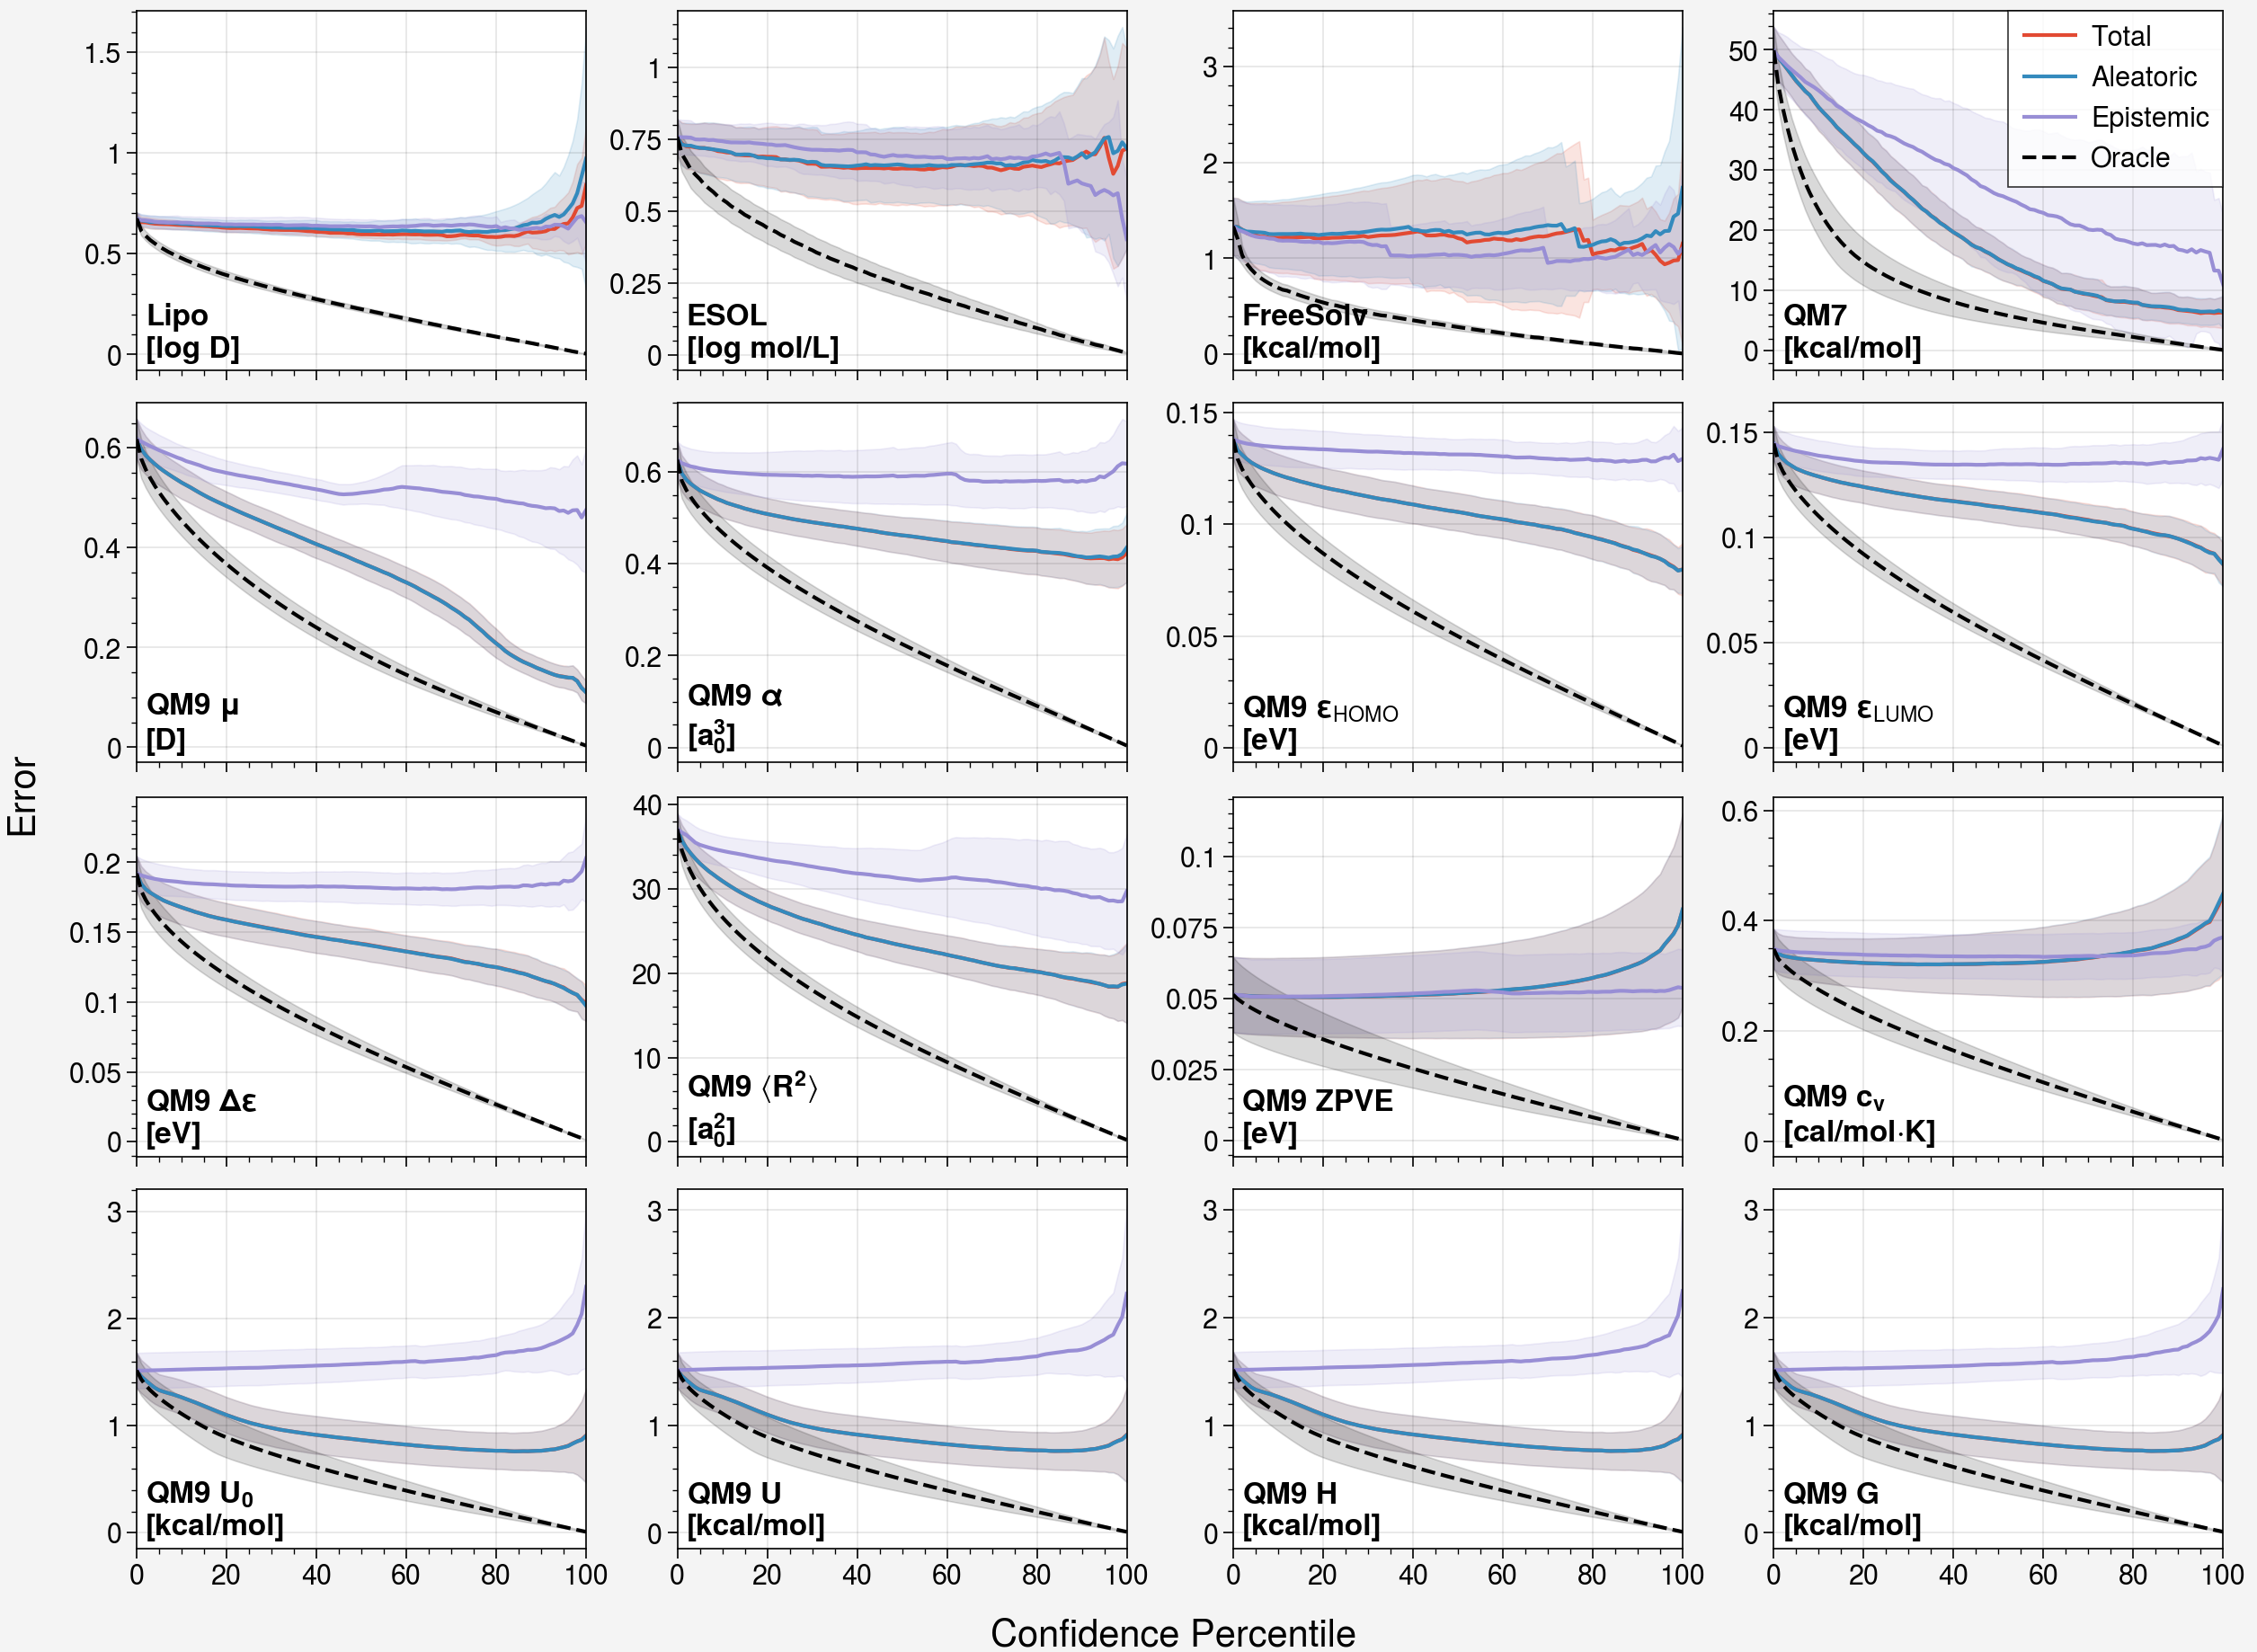

In [26]:
with open("/scratch/gpfs/sj0161/autognnuq/result/val_test_result_mc_dropout.pickle", "rb") as handle:
    result = pickle.load(handle)
    
with open("/scratch/gpfs/sj0161/autognnuq/result/val_test_result_qm9_mc_dropout.pickle", "rb") as handle:
    result_qm9 = pickle.load(handle)

fig, ax = pplt.subplots(refheight=2, refwidth=2.5, ncols=4, nrows=4, sharey=False)



for i in range(16):
    oracle = np.zeros((8, 101))
    err_ale = np.zeros((8, 101))
    err_epi = np.zeros((8, 101))
    err_tot = np.zeros((8, 101))

    if i == 0:
        dataset = "lipo"
    elif i == 1:
        dataset = "delaney"
    elif i == 2:
        dataset = "freesolv"
    elif i == 3:
        dataset = "qm7"
    else:
        dataset = "qm9"

    if i >= 3:
        mode = "mae"
        ylabel = "MAE"
    else:
        mode = "rmse"
        ylabel = "RMSE"

    for seed in range(8):
        if dataset == "qm9":
            split = "811"

            y_true, y_pred, y_epis, y_alea, v_true, v_pred, v_epis, v_alea = (
                result_qm9[dataset, split, seed]
            )
            y_true = np.copy(y_true)[..., i - 4]
            y_pred = np.copy(y_pred)[..., i - 4]
            y_alea = np.copy(y_alea)[..., i - 4]
            y_epis = np.copy(y_epis)[..., i - 4]

            if i in [6, 7, 8, 10]:
                y_true = y_true * 27.2114
                y_pred = y_pred * 27.2114
                y_alea = y_alea * (27.2114**2)
                y_epis = y_epis * (27.2114**2)

        else:
            split = "523"

            y_true, y_pred, y_epis, y_alea, v_true, v_pred, v_epis, v_alea = result[
                dataset, split, seed
            ]

        err = np.abs(y_true-y_pred)

        p, oracle[seed] = conf_curve(err, err, mode=mode)
        _, err_ale[seed] = conf_curve(err, y_alea ** 0.5, mode=mode)
        _, err_epi[seed] = conf_curve(err, y_epis ** 0.5, mode=mode)
        _, err_tot[seed] = conf_curve(err, (y_alea+y_epis) ** 0.5, mode=mode)


    ax[i].plot(p, err_tot.mean(axis=0), label="Total", c=COLOR[0])
    ax[i].fill_between(p,  
                    err_tot.mean(axis=0)-err_tot.std(axis=0),
                    err_tot.mean(axis=0)+err_tot.std(axis=0), c=COLOR[0], alpha=0.15)

    ax[i].plot(p, err_ale.mean(axis=0), label="Aleatoric", c=COLOR[1])
    ax[i].fill_between(p,  
                    err_ale.mean(axis=0)-err_ale.std(axis=0), 
                    err_ale.mean(axis=0)+err_ale.std(axis=0), c=COLOR[1], alpha=0.15)

    ax[i].plot(p, err_epi.mean(axis=0), label="Epistemic", c=COLOR[2])
    ax[i].fill_between(p,  
                    err_epi.mean(axis=0)-err_epi.std(axis=0), 
                    err_epi.mean(axis=0)+err_epi.std(axis=0), c=COLOR[2], alpha=0.15)

    ax[i].plot(p, oracle.mean(axis=0), 'k--', label="Oracle")

    ax[i].fill_between(p,  
                    oracle.mean(axis=0)-oracle.std(axis=0), 
                    oracle.mean(axis=0)+oracle.std(axis=0), c="#000000", alpha=0.15)

    ax[i].text(
        0.02,
        0.02,
        LABELS[i],
        ha="left",
        va="bottom",
        transform=ax[i].transAxes,
        fontsize=12,
        color="k",
        weight="bold",
    )
    

    ax[i].format(
        xlabelsize=14,
        ylabelsize=14,
        xticklabelsize=11,
        yticklabelsize=11,
        xlim=[0, 100],
    )

    if i == 3:
        ax[i].legend(ncol=1, loc="upper right", prop={"size": 11})
        
        
    err_cut = err_tot[:, [0, 50, 75, 90, 95]].mean(axis=0)
    err_cut_std = err_tot[:, [0, 50, 75, 90, 95]].std(axis=0) / (8 ** 0.5)

#     print(fr"{name:<10} {err_cut[0]:0.2f} ({err_cut_std[0]:0.2f}) & {err_cut[1]:0.2f} ({err_cut_std[1]:0.2f}) & {err_cut[2]:0.2f} ({err_cut_std[2]:0.2f}) & {err_cut[3]:0.2f} ({err_cut_std[3]:0.2f}) & {err_cut[4]:0.2f} ({err_cut_std[4]:0.2f})")
    

    # calculate auco, area under the confidence-oracle error
    print("AUCO:")
    print(f"Total: {(err_tot-oracle).sum(axis=1).mean():0.2f} ({(err_tot-oracle).sum(axis=1).std():0.2f})")
#     print(f"Aleatoric: {(err_ale-oracle).sum(axis=1).mean():0.2f} +/- {(err_ale-oracle).sum(axis=1).std():0.2f}")
#     print(f"Epistemic: {(err_epi-oracle).sum(axis=1).mean():0.2f} +/- {(err_epi-oracle).sum(axis=1).std():0.2f}")


    # calculate decreasing coeffcient
#     print()
#     print("Decreasing Coeffcient:")
#     print(f"Oracle: {np.mean([decreasing_coefficient(oracle[i]) for i in range(8)]):0.2f} +/- {np.std([decreasing_coefficient(oracle[i]) for i in range(8)]):0.2f}")
#     print(f"Total: {np.mean([decreasing_coefficient(err_tot[i]) for i in range(8)]):0.2f} +/- {np.std([decreasing_coefficient(err_tot[i]) for i in range(8)]):0.2f}")
#     print(f"Aleatoric: {np.mean([decreasing_coefficient(err_ale[i]) for i in range(8)]):0.2f} +/- {np.std([decreasing_coefficient(err_ale[i]) for i in range(8)]):0.2f}")
#     print(f"Epistemic: {np.mean([decreasing_coefficient(err_epi[i]) for i in range(8)]):0.2f} +/- {np.std([decreasing_coefficient(err_epi[i]) for i in range(8)]):0.2f}")

#     name = LABELS[i].split('\n')[0]
    

fig.text(
    0.01,
    0.52,
    "Error",
    va="center",
    ha="center",
    rotation="vertical",
    fontsize=15,
    transform=fig.transFigure
)
fig.text(
    0.52,
    0.01,
    "Confidence Percentile",
    va="center",
    ha="center",
    rotation=0,
    fontsize=15,
    transform=fig.transFigure,
)


out_file = os.path.join(PLOT_DIR, f"conf_cutoff_mc_dropout.pdf")

fig.save(out_file, bbox_inches="tight", dpi=600)

AUCO:
Total: 32.16 (1.66)
AUCO:
Total: 34.67 (2.71)
AUCO:
Total: 48.63 (9.66)
AUCO:
Total: 1332.97 (191.13)
AUCO:
Total: 26.11 (2.35)
AUCO:
Total: 32.47 (4.82)
AUCO:
Total: 8.14 (0.47)
AUCO:
Total: 8.91 (0.86)
AUCO:
Total: 12.38 (1.21)
AUCO:
Total: 1887.69 (293.54)
AUCO:
Total: 1.45 (0.64)
AUCO:
Total: 16.17 (2.95)
AUCO:
Total: 20.86 (17.48)
AUCO:
Total: 20.81 (17.27)
AUCO:
Total: 20.80 (17.29)
AUCO:
Total: 20.72 (17.10)


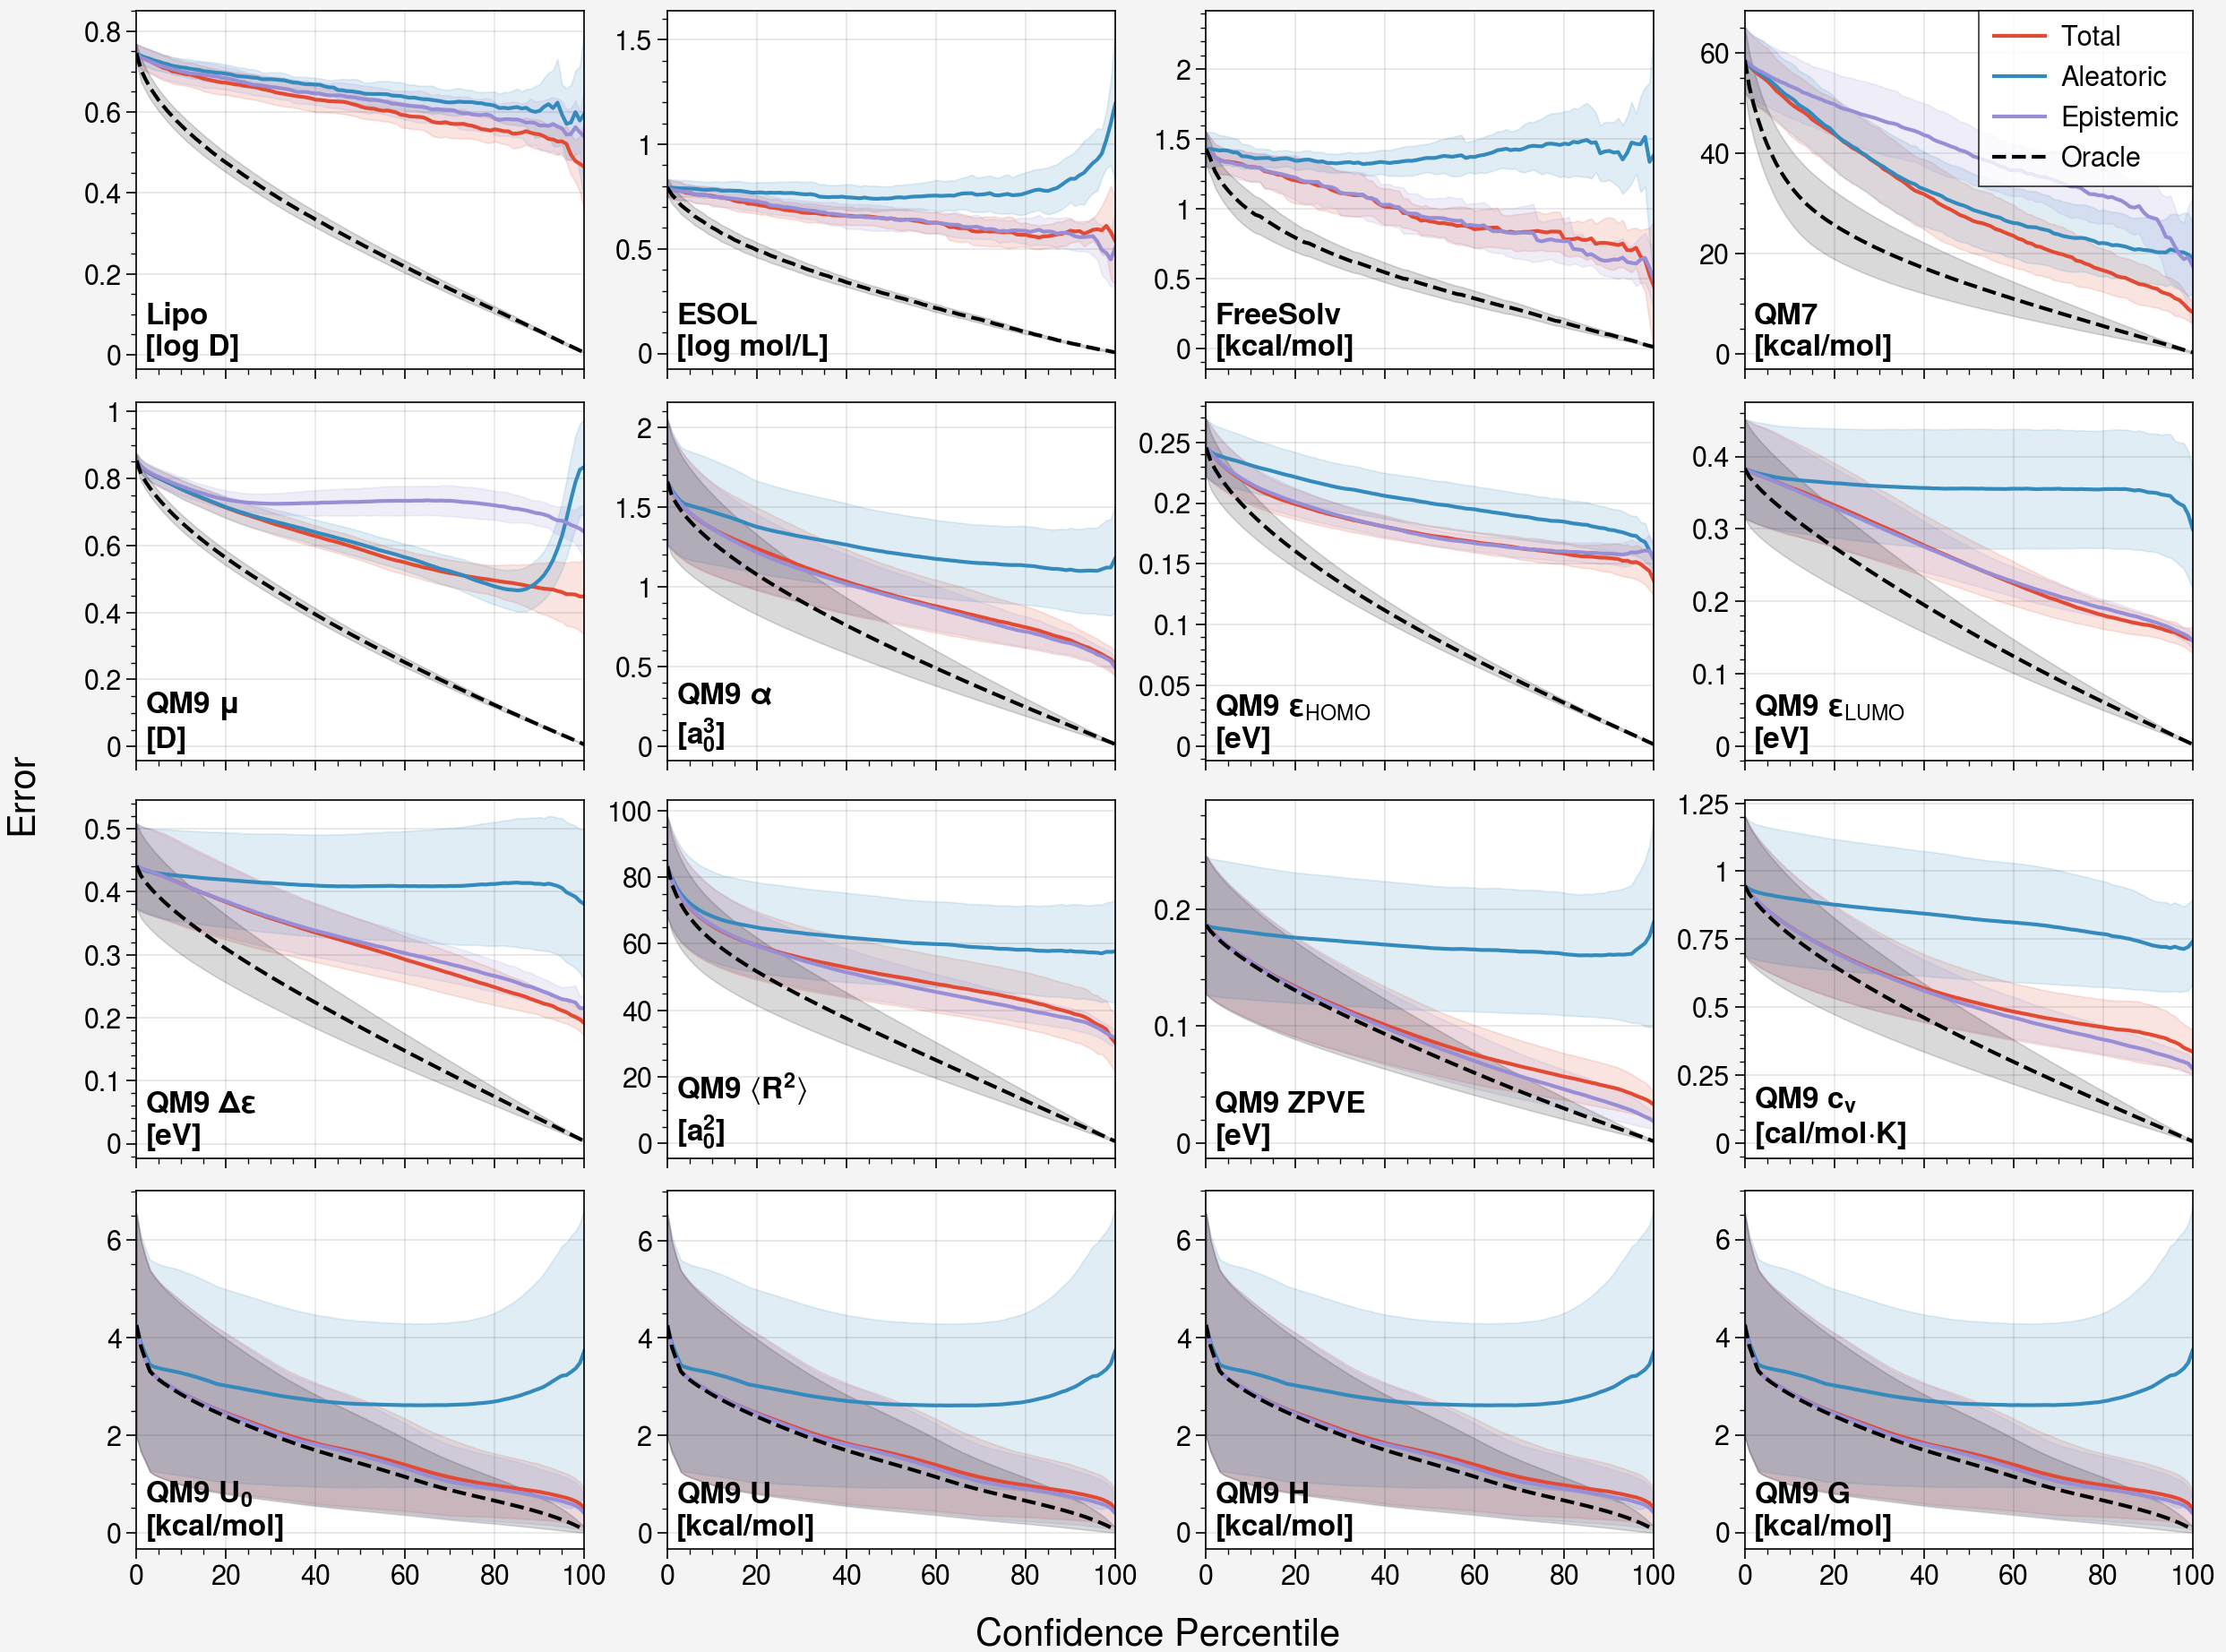

In [28]:
with open("/scratch/gpfs/sj0161/autognnuq/result/val_test_result_random.pickle", "rb") as handle:
    result = pickle.load(handle)
    
with open("/scratch/gpfs/sj0161/autognnuq/result/val_test_result_qm9_random.pickle", "rb") as handle:
    result_qm9 = pickle.load(handle)

fig, ax = pplt.subplots(refheight=2, refwidth=2.5, ncols=4, nrows=4, sharey=False)



for i in range(16):
    oracle = np.zeros((8, 101))
    err_ale = np.zeros((8, 101))
    err_epi = np.zeros((8, 101))
    err_tot = np.zeros((8, 101))

    if i == 0:
        dataset = "lipo"
    elif i == 1:
        dataset = "delaney"
    elif i == 2:
        dataset = "freesolv"
    elif i == 3:
        dataset = "qm7"
    else:
        dataset = "qm9"

    if i >= 3:
        mode = "mae"
        ylabel = "MAE"
    else:
        mode = "rmse"
        ylabel = "RMSE"

    for seed in range(8):
        if dataset == "qm9":
            split = "811"

            y_true, y_pred, y_epis, y_alea, v_true, v_pred, v_epis, v_alea = (
                result_qm9[dataset, split, seed]
            )
            y_true = np.copy(y_true)[..., i - 4]
            y_pred = np.copy(y_pred)[..., i - 4]
            y_alea = np.copy(y_alea)[..., i - 4]
            y_epis = np.copy(y_epis)[..., i - 4]

            if i in [6, 7, 8, 10]:
                y_true = y_true * 27.2114
                y_pred = y_pred * 27.2114
                y_alea = y_alea * (27.2114**2)
                y_epis = y_epis * (27.2114**2)

        else:
            split = "523"

            y_true, y_pred, y_epis, y_alea, v_true, v_pred, v_epis, v_alea = result[
                dataset, split, seed
            ]

        err = np.abs(y_true-y_pred)

        p, oracle[seed] = conf_curve(err, err, mode=mode)
        _, err_ale[seed] = conf_curve(err, y_alea ** 0.5, mode=mode)
        _, err_epi[seed] = conf_curve(err, y_epis ** 0.5, mode=mode)
        _, err_tot[seed] = conf_curve(err, (y_alea+y_epis) ** 0.5, mode=mode)


    ax[i].plot(p, err_tot.mean(axis=0), label="Total", c=COLOR[0])
    ax[i].fill_between(p,  
                    err_tot.mean(axis=0)-err_tot.std(axis=0),
                    err_tot.mean(axis=0)+err_tot.std(axis=0), c=COLOR[0], alpha=0.15)

    ax[i].plot(p, err_ale.mean(axis=0), label="Aleatoric", c=COLOR[1])
    ax[i].fill_between(p,  
                    err_ale.mean(axis=0)-err_ale.std(axis=0), 
                    err_ale.mean(axis=0)+err_ale.std(axis=0), c=COLOR[1], alpha=0.15)

    ax[i].plot(p, err_epi.mean(axis=0), label="Epistemic", c=COLOR[2])
    ax[i].fill_between(p,  
                    err_epi.mean(axis=0)-err_epi.std(axis=0), 
                    err_epi.mean(axis=0)+err_epi.std(axis=0), c=COLOR[2], alpha=0.15)

    ax[i].plot(p, oracle.mean(axis=0), 'k--', label="Oracle")

    ax[i].fill_between(p,  
                    oracle.mean(axis=0)-oracle.std(axis=0), 
                    oracle.mean(axis=0)+oracle.std(axis=0), c="#000000", alpha=0.15)

    ax[i].text(
        0.02,
        0.02,
        LABELS[i],
        ha="left",
        va="bottom",
        transform=ax[i].transAxes,
        fontsize=12,
        color="k",
        weight="bold",
    )
    

    ax[i].format(
        xlabelsize=14,
        ylabelsize=14,
        xticklabelsize=11,
        yticklabelsize=11,
        xlim=[0, 100],
    )

    if i == 3:
        ax[i].legend(ncol=1, loc="upper right", prop={"size": 11})
        
        
    err_cut = err_tot[:, [0, 50, 75, 90, 95]].mean(axis=0)
    err_cut_std = err_tot[:, [0, 50, 75, 90, 95]].std(axis=0) / (8 ** 0.5)

#     print(fr"{name:<10} {err_cut[0]:0.2f} ({err_cut_std[0]:0.2f}) & {err_cut[1]:0.2f} ({err_cut_std[1]:0.2f}) & {err_cut[2]:0.2f} ({err_cut_std[2]:0.2f}) & {err_cut[3]:0.2f} ({err_cut_std[3]:0.2f}) & {err_cut[4]:0.2f} ({err_cut_std[4]:0.2f})")
    

    # calculate auco, area under the confidence-oracle error
    print("AUCO:")
    print(f"Total: {(err_tot-oracle).sum(axis=1).mean():0.2f} ({(err_tot-oracle).sum(axis=1).std():0.2f})")
#     print(f"Aleatoric: {(err_ale-oracle).sum(axis=1).mean():0.2f} +/- {(err_ale-oracle).sum(axis=1).std():0.2f}")
#     print(f"Epistemic: {(err_epi-oracle).sum(axis=1).mean():0.2f} +/- {(err_epi-oracle).sum(axis=1).std():0.2f}")


    # calculate decreasing coeffcient
#     print()
#     print("Decreasing Coeffcient:")
#     print(f"Oracle: {np.mean([decreasing_coefficient(oracle[i]) for i in range(8)]):0.2f} +/- {np.std([decreasing_coefficient(oracle[i]) for i in range(8)]):0.2f}")
#     print(f"Total: {np.mean([decreasing_coefficient(err_tot[i]) for i in range(8)]):0.2f} +/- {np.std([decreasing_coefficient(err_tot[i]) for i in range(8)]):0.2f}")
#     print(f"Aleatoric: {np.mean([decreasing_coefficient(err_ale[i]) for i in range(8)]):0.2f} +/- {np.std([decreasing_coefficient(err_ale[i]) for i in range(8)]):0.2f}")
#     print(f"Epistemic: {np.mean([decreasing_coefficient(err_epi[i]) for i in range(8)]):0.2f} +/- {np.std([decreasing_coefficient(err_epi[i]) for i in range(8)]):0.2f}")

#     name = LABELS[i].split('\n')[0]
    

fig.text(
    0.01,
    0.52,
    "Error",
    va="center",
    ha="center",
    rotation="vertical",
    fontsize=15,
    transform=fig.transFigure
)
fig.text(
    0.52,
    0.01,
    "Confidence Percentile",
    va="center",
    ha="center",
    rotation=0,
    fontsize=15,
    transform=fig.transFigure,
)


out_file = os.path.join(PLOT_DIR, f"conf_cutoff_random.pdf")

fig.save(out_file, bbox_inches="tight", dpi=600)

In [46]:
losses = []
val_losses = []

for seed in tqdm(range(8)):

    MODEL_DIR = os.path.join(
        ROOT_DIR, f"NEW_RE_lipo_random_{seed}_split_523/save/model/"
    )
    arch_path = MODEL_DIR.split("save")[0] + "results.csv"
    df = pd.read_csv(arch_path)
    loss_min = []
    arch_min = []
    id_min = []

    for i in range(len(df)):
        loss_min_ = np.argsort(df["objective"])[::-1].values[i]
        arch_min_ = df["p:arch_seq"][loss_min_]
        id_min_ = df["job_id"][loss_min_]

        if not any(np.array_equal(arch_min_, x) for x in arch_min):
            loss_min.append(loss_min_)
            arch_min.append(arch_min_)
            id_min.append(id_min_)

    for i in range(10):
        file = f"/scratch/gpfs/sj0161/autognnuq/NEW_POST_RESULT/post_result_lipo_random_{seed}_split_523/test_{id_min[i]}.pickle"
        with open(file, "rb") as handle:
            _ = pickle.load(handle)
            _ = pickle.load(handle)
            _ = pickle.load(handle)
            hist = pickle.load(handle)

        val_loss_temp = hist["val_loss"]
        loss_temp = hist["loss"]

        val_loss = np.ones(1000) * val_loss_temp[-1]
        loss = np.ones(1000) * loss_temp[-1]

        val_loss[:len(val_loss_temp)] = val_loss_temp
        loss[:len(loss_temp)] = loss_temp   

        losses.append(loss)
        val_losses.append(val_loss)
    
loss = np.array(losses)
val_loss = np.array(val_losses)

100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


[ 99 220 191 157 121 106  91  76 141  65 130  87 121  61  63 111  54  84
 138  56  89  64  91  67  78 112  89 102  84  72  60 117  81 106 118 135
  71  73  80  88  83  96  85  81 137 128  65 112  86 104  90  66 111 128
 286  63  93 105  42  93  59 111 137 116 260  86  60 108 137  85 115  67
 120  35 106 116  74  95 103 106]


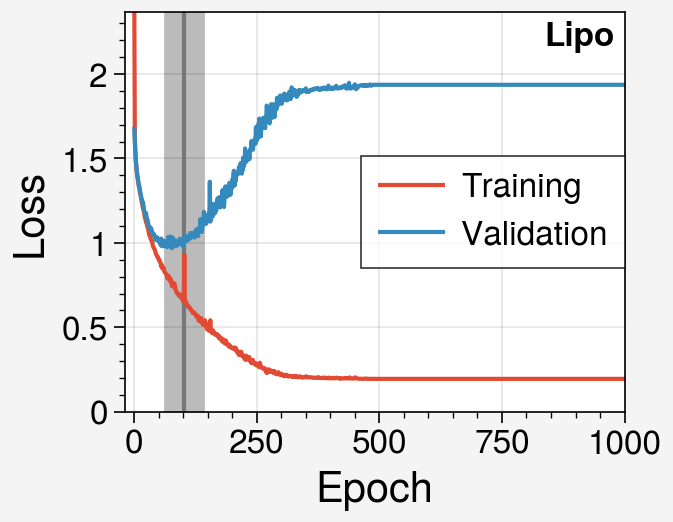

In [96]:
fig, ax = pplt.subplots(refheight=2, refwidth=2.5)

xx = np.arange(1000)

val_loss_mean = val_loss.argmin(axis=1).mean()
val_loss_std = val_loss.argmin(axis=1).std()
vmax = max([max(loss.mean(axis=0)), max(val_loss.mean(axis=0))])

ax.plot(xx, loss.mean(axis=0), c=COLOR[0], label="Training")
ax.plot(xx, val_loss.mean(axis=0), c=COLOR[1], label="Validation")
ax.vlines(val_loss_mean, vmax, c=COLOR[3])
ax.fill_betweenx([0, vmax], val_loss_mean-val_loss_std, val_loss_mean+val_loss_std, c=sat(COLOR[3]))

ax.legend(loc="center right", prop={"size": 12}, ncol=1)
ax.format(
    xlabel="Epoch",
    ylabel="Loss",
    xlim=[-20, 1000],
    xticklabelsize=12,
    yticklabelsize=12,
    xlabelsize=15,
    ylabelsize=15,
    xticks=[0, 250, 500, 750, 1000],
)

ax.text(
    0.98,
    0.98,
    "Lipo",
    ha="right",
    va="top",
    transform=ax.transAxes,
    fontsize=12,
    color="k",
    weight="bold",
)

print(np.argmin(val_loss, axis=1))

In [4]:
from deephyper.gnn_uq.figure import plot_loss_curve

lipo converge ratio: 0.75 (0.09) 30 epoch: 0.90 (0.06) min: 1.10 (0.08)
delaney converge ratio: 0.71 (0.11) 30 epoch: 0.43 (0.14) min: 0.82 (0.09)
freesolv converge ratio: 0.65 (0.09) 30 epoch: 0.32 (0.18) min: 0.85 (0.19)
qm7 converge ratio: 0.59 (0.10) 30 epoch: 0.20 (0.15) min: 0.70 (0.09)
qm9 converge ratio: 0.73 (0.05) 30 epoch: -2.25 (0.18) min: -1.38 (0.27)


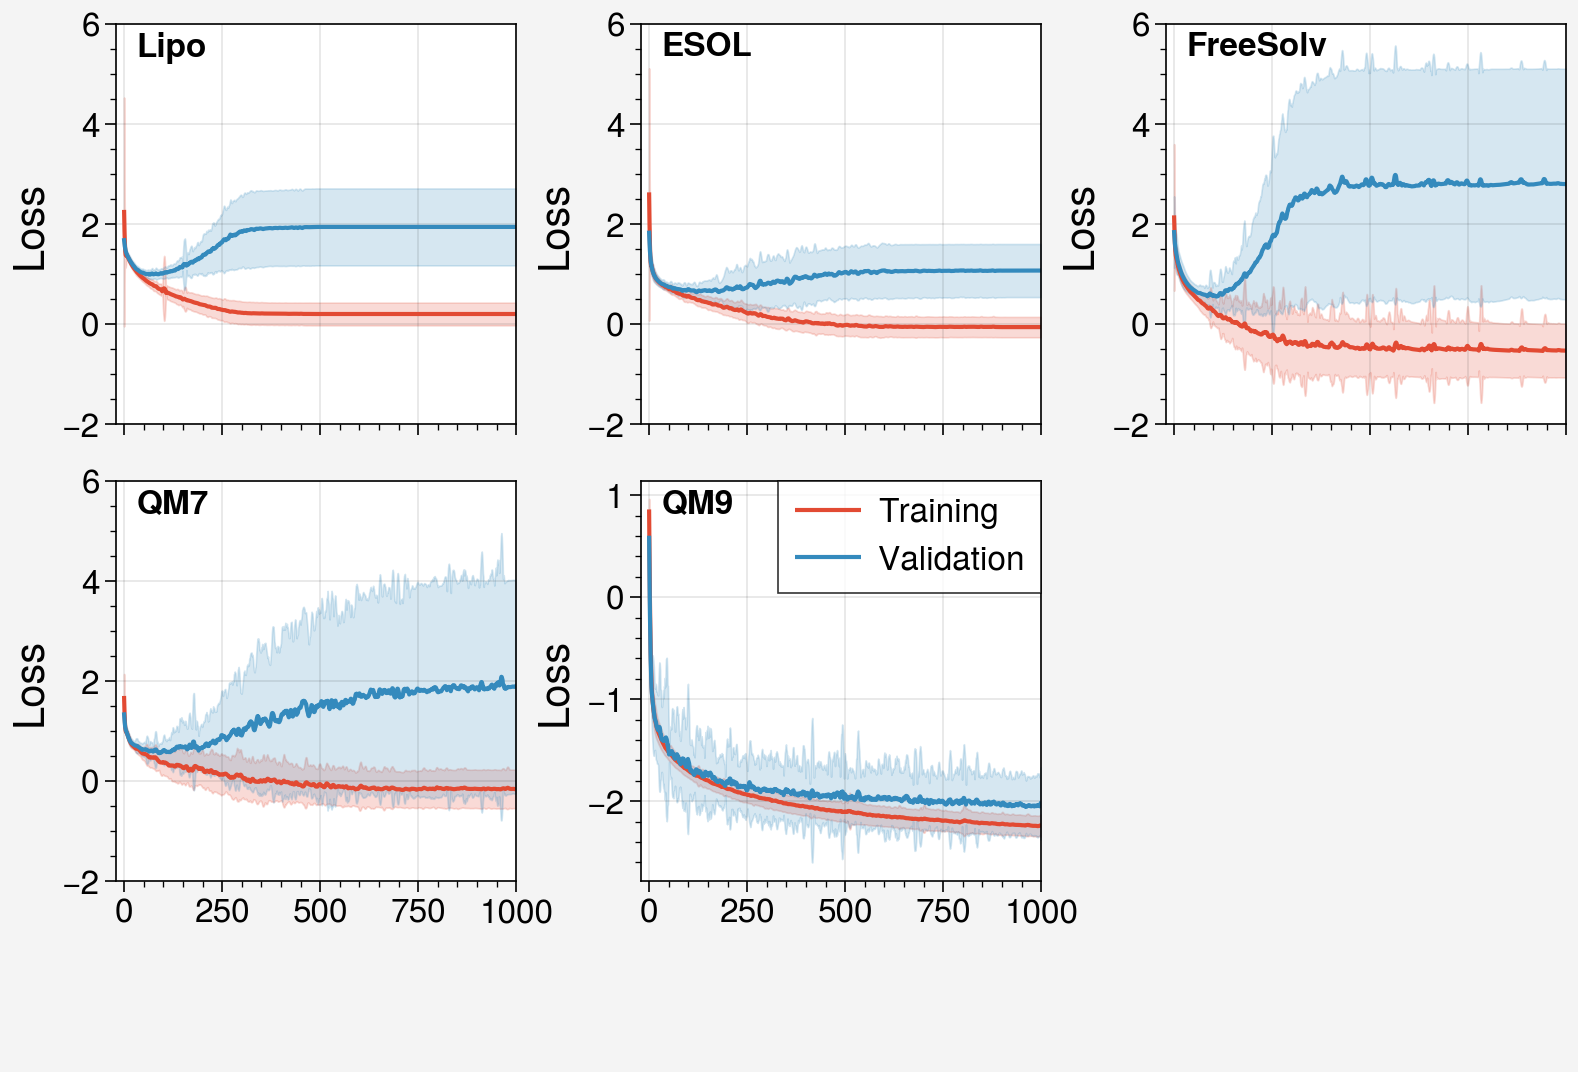

In [61]:
plot_loss_curve(ROOT_DIR, RESULT_DIR, COLOR, PLOT_DIR, format="pdf")

lipo converge ratio: 0.91 (0.14) 30 epoch: 1.17 (0.16) min: 1.28 (0.12)
delaney converge ratio: 0.80 (0.12) 30 epoch: 0.50 (0.14) min: 0.91 (0.12)
freesolv converge ratio: 0.61 (0.15) 30 epoch: 0.58 (0.29) min: 1.16 (0.28)
qm7 converge ratio: 0.60 (0.09) 30 epoch: 0.23 (0.15) min: 0.72 (0.12)
qm9 converge ratio: 0.64 (0.09) 30 epoch: -1.97 (0.20) min: -0.99 (0.23)


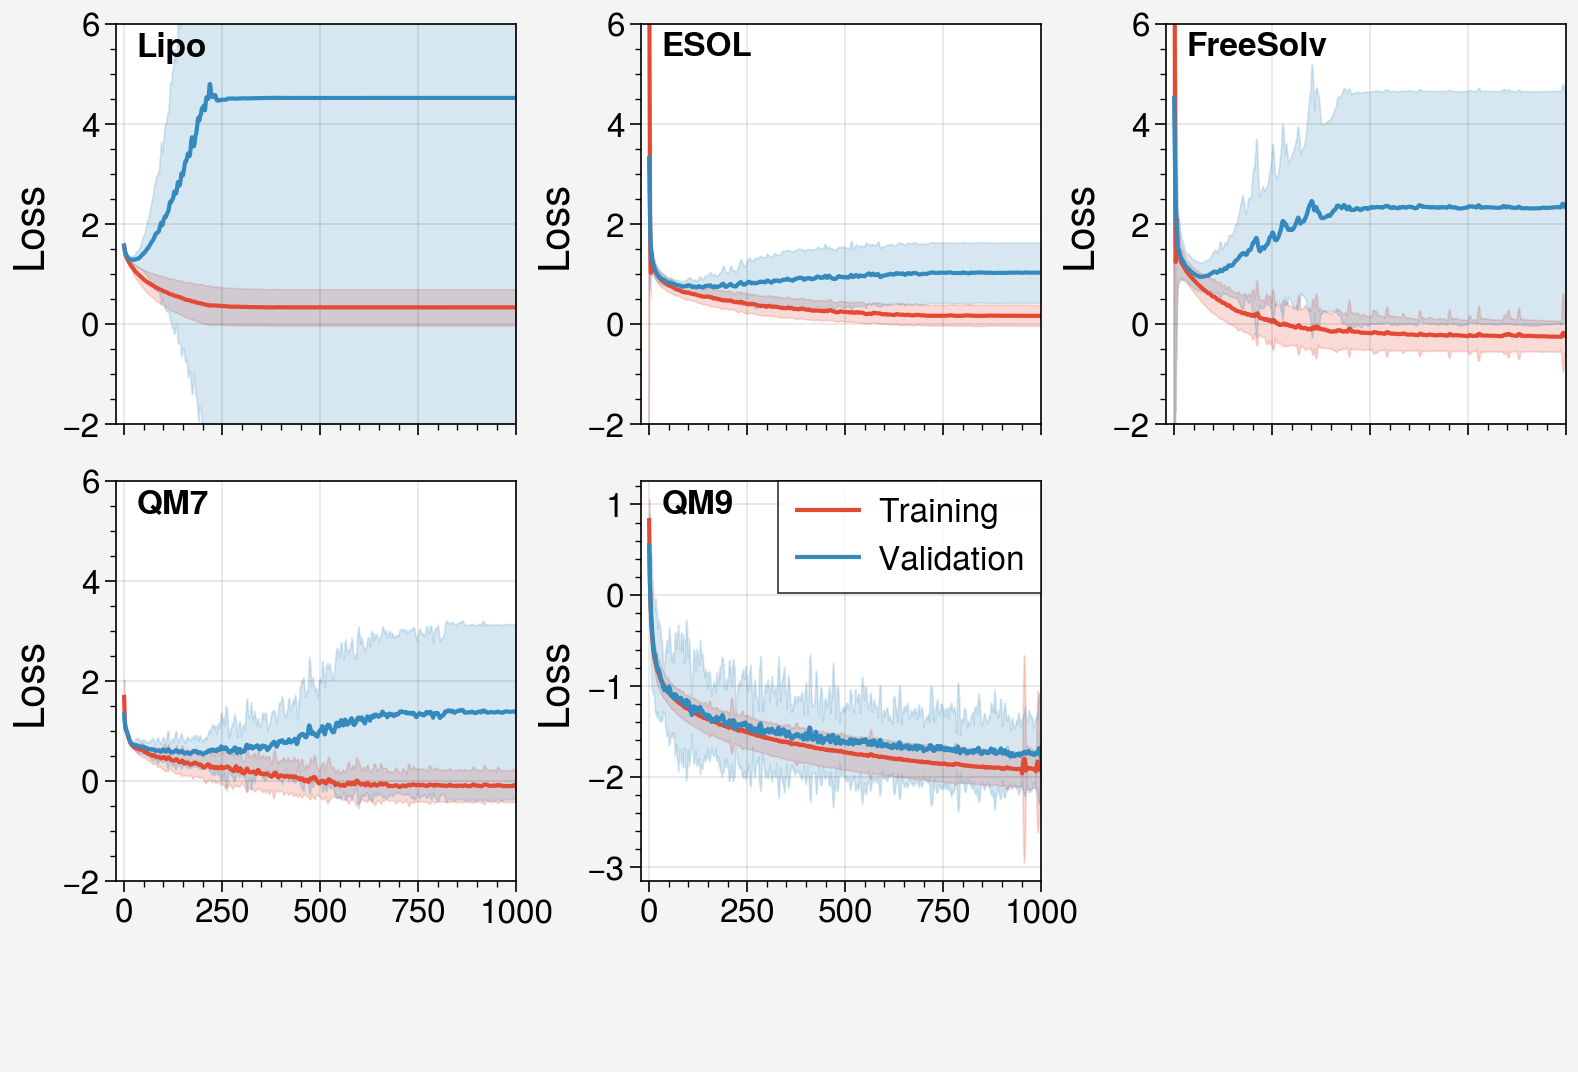

In [58]:
plot_loss_curve(ROOT_DIR, RESULT_DIR, COLOR, PLOT_DIR, format="pdf", if_simple=True)

In [63]:
def err_unc(RESULT_DIR, PLOT_DIR, COLOR, format="pdf"):
    LABELS = [
        "Lipo" + "\n" + "[log D]",
        "ESOL" + "\n" + "[log mol/L]",
        "FreeSolv" + "\n" + "[kcal/mol]",
        "QM7" + "\n" + "[kcal/mol]",
        r"QM9 $\mu$" + "\n" + "[D]",
        r"QM9 $\alpha$" + "\n" + r"[$a_0^3$]",
        r"QM9 $\epsilon_{\mathrm{HOMO}}$" + "\n" + "[eV]",
        r"QM9 $\epsilon_{\mathrm{LUMO}}$" + "\n" + "[eV]",
        r"QM9 $\Delta \epsilon$" + "\n" + "[eV]",
        r"QM9 $\langle R^2 \rangle$" + "\n" + r"[$a_0^2$]",
        r"QM9 ZPVE" + "\n" + "[eV]",
        r"QM9 $c_v$" + "\n" + "[cal/mol$\cdot$K]",
        r"QM9 $U_0$" + "\n" + "[kcal/mol]",
        r"QM9 $U$" + "\n" + "[kcal/mol]",
        r"QM9 $H$" + "\n" + "[kcal/mol]",
        r"QM9 $G$" + "\n" + "[kcal/mol]",
    ]
    result_file = os.path.join(RESULT_DIR, "val_test_result.pickle")
    qm9_result_file = os.path.join(RESULT_DIR, "val_test_result_qm9.pickle")

    with open(result_file, "rb") as handle:
        result = pickle.load(handle)

    with open(qm9_result_file, "rb") as handle:
        result_qm9 = pickle.load(handle)

    ratios = []
    for seed in range(8):
        ratio = np.zeros((16, 3))

        for i in range(16):
            if i == 0:
                dataset = "lipo"
            elif i == 1:
                dataset = "delaney"
            elif i == 2:
                dataset = "freesolv"
            elif i == 3:
                dataset = "qm7"
            else:
                dataset = "qm9"

            if dataset == "qm9":
                split = "811"

                y_true, y_pred, y_epis, y_alea, v_true, v_pred, v_epis, v_alea = (
                    result_qm9[dataset, split, seed]
                )
                y_true = np.copy(y_true)[..., i - 4]
                y_pred = np.copy(y_pred)[..., i - 4]
                y_alea = np.copy(y_alea)[..., i - 4]
                y_epis = np.copy(y_epis)[..., i - 4]

                if i in [6, 7, 8, 10]:
                    y_true = y_true * 27.2114
                    y_pred = y_pred * 27.2114
                    y_alea = y_alea * (27.2114**2)
                    y_epis = y_epis * (27.2114**2)

            else:
                split = "523"

                y_true, y_pred, y_epis, y_alea, v_true, v_pred, v_epis, v_alea = result[
                    dataset, split, seed
                ]

            std = (y_alea + y_epis) ** 0.5
            dif = y_true - y_pred

            idx1 = np.where(np.abs(dif) - 2 * std >= 0)[0]
            idx2 = np.where(np.abs(dif) - 2 * std < 0)[0]
            idx3 = np.where(np.abs(dif) - 1 * std < 0)[0]

            ratio[i, 0] = len(idx1) / len(std)
            ratio[i, 1] = (len(idx2) - len(idx3)) / len(std)
            ratio[i, 2] = (len(idx3)) / len(std)
            
        ratios.append(ratio)
    ratios = np.array(ratios)
    return ratios

In [65]:
ratios = err_unc(RESULT_DIR, PLOT_DIR, COLOR, format="pdf")

In [67]:
ratios.shape

(8, 16, 3)

In [78]:
ratios[:, 4:, :].mean(axis=0) * 100

array([[2.67010232e+00, 2.15045933e+01, 7.58253044e+01],
       [1.85226679e+00, 1.62857570e+01, 8.18619762e+01],
       [2.02124879e+00, 1.84741205e+01, 7.95046307e+01],
       [1.69822242e+00, 1.60234147e+01, 8.22783628e+01],
       [1.85506759e+00, 1.72090896e+01, 8.09358429e+01],
       [2.12861304e+00, 1.69318097e+01, 8.09395773e+01],
       [1.03536485e+00, 1.21583016e+01, 8.68063336e+01],
       [1.78598103e+00, 1.43261259e+01, 8.38878930e+01],
       [3.73440884e-03, 2.24064531e-02, 9.99738591e+01],
       [3.73440884e-03, 1.96056464e-02, 9.99766599e+01],
       [3.73440884e-03, 1.96056464e-02, 9.99766599e+01],
       [3.73440884e-03, 1.86720442e-02, 9.99775935e+01]])

In [79]:
ratios[:, 4:, :].std(axis=0) * 100

array([[0.25705106, 1.03992223, 1.12647222],
       [0.21858258, 0.42916466, 0.50146868],
       [0.21501043, 0.80299343, 0.93202823],
       [0.29805022, 0.80422502, 1.01512574],
       [0.28312478, 0.71106358, 0.91693997],
       [0.1283355 , 0.81964957, 0.8649007 ],
       [0.26421932, 1.96865495, 2.21829858],
       [0.25085772, 0.94159279, 1.09454338],
       [0.00528125, 0.01397288, 0.01584375],
       [0.00528125, 0.01177228, 0.01418953],
       [0.00528125, 0.01443314, 0.01768924],
       [0.00528125, 0.01627791, 0.01867204]])

In [77]:
2.57051055e-03

0.00257051055

In [4]:
import uncertainty_toolbox as uct
from deephyper.gnn_uq.figure import sat
from deephyper.gnn_uq.analysis import conf_level, miscal_area


def conf_calib(RESULT_DIR, PLOT_DIR, COLOR, format="pdf"):
    
    ratios = []
    LABELS = [
        "Lipo" + "\n" + "[log D]",
        "ESOL" + "\n" + "[log mol/L]",
        "FreeSolv" + "\n" + "[kcal/mol]",
        "QM7" + "\n" + "[kcal/mol]",
        r"QM9 $\mu$" + "\n" + "[D]",
        r"QM9 $\alpha$" + "\n" + r"[$a_0^3$]",
        r"QM9 $\epsilon_{\mathrm{HOMO}}$" + "\n" + "[eV]",
        r"QM9 $\epsilon_{\mathrm{LUMO}}$" + "\n" + "[eV]",
        r"QM9 $\Delta \epsilon$" + "\n" + "[eV]",
        r"QM9 $\langle R^2 \rangle$" + "\n" + r"[$a_0^2$]",
        r"QM9 ZPVE" + "\n" + "[eV]",
        r"QM9 $c_v$" + "\n" + "[cal/mol$\cdot$K]",
        r"QM9 $U_0$" + "\n" + "[kcal/mol]",
        r"QM9 $U$" + "\n" + "[kcal/mol]",
        r"QM9 $H$" + "\n" + "[kcal/mol]",
        r"QM9 $G$" + "\n" + "[kcal/mol]",
    ]
    result_file = os.path.join(RESULT_DIR, "val_test_result.pickle")
    qm9_result_file = os.path.join(RESULT_DIR, "val_test_result_qm9.pickle")

    with open(result_file, "rb") as handle:
        result = pickle.load(handle)

    with open(qm9_result_file, "rb") as handle:
        result_qm9 = pickle.load(handle)

        
    for i in range(16):
        perc_tot = np.zeros((8, 100))
        perc_ale = np.zeros((8, 100))
        perc_epi = np.zeros((8, 100))
        MCA = np.zeros((8,))
        ratio = np.zeros((8,))

        if i == 0:
            dataset = "lipo"
        elif i == 1:
            dataset = "delaney"
        elif i == 2:
            dataset = "freesolv"
        elif i == 3:
            dataset = "qm7"
        else:
            dataset = "qm9"

        for seed in range(8):
            if dataset == "qm9":
                split = "811"

                y_true, y_pred, y_epis, y_alea, v_true, v_pred, v_epis, v_alea = (
                    result_qm9[dataset, split, seed]
                )
                y_true = np.copy(y_true)[..., i - 4]
                y_pred = np.copy(y_pred)[..., i - 4]
                y_alea = np.copy(y_alea)[..., i - 4]
                y_epis = np.copy(y_epis)[..., i - 4]
                v_true = np.copy(v_true)[..., i - 4]
                v_pred = np.copy(v_pred)[..., i - 4]
                v_alea = np.copy(v_alea)[..., i - 4]
                v_epis = np.copy(v_epis)[..., i - 4]

                if i in [6, 7, 8, 10]:
                    y_true = y_true * 27.2114
                    y_pred = y_pred * 27.2114
                    y_alea = y_alea * (27.2114**2)
                    y_epis = y_epis * (27.2114**2)

                    v_true = v_true * 27.2114
                    v_pred = v_pred * 27.2114
                    v_alea = v_alea * (27.2114**2)
                    v_epis = v_epis * (27.2114**2)

            else:
                split = "523"

                y_true, y_pred, y_epis, y_alea, v_true, v_pred, v_epis, v_alea = result[
                    dataset, split, seed
                ]

            a = uct.recalibration.optimize_recalibration_ratio(
                y_mean=v_pred,
                y_std=(v_alea + v_epis) ** 0.5,
                y_true=v_true,
                criterion="miscal",
            )
            
            ratio[seed] = a
            
        ratios.append(ratio)
        
    ratios = np.array(ratios)
    return ratios


In [5]:
ratios = conf_calib(RESULT_DIR, PLOT_DIR, COLOR, format="pdf")

In [6]:
ratios.shape

(16, 8)

In [7]:
ratios.mean(axis=1)

array([0.84589904, 0.8441395 , 0.5622481 , 0.27595991, 0.84700932,
       0.72122526, 0.77272643, 0.70936846, 0.73401558, 0.73194928,
       0.61673035, 0.66996677, 0.12597743, 0.11245392, 0.13385823,
       0.11362477])